#### Imported Libraries:

In [42]:
import cv2
import os
import numpy as np



import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from scikeras.wrappers import KerasClassifier

import random

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, roc_curve, auc

import types
import pickle


##### constants:

In [3]:
img_height = 100
img_width = 100

#### Load Data

In [4]:
def resize_without_squeezing(image, target_size):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    # Calculate new size while preserving aspect ratio
    if aspect_ratio > 1:
        new_w = target_size
        new_h = int(target_size / aspect_ratio)
    else:
        new_h = target_size
        new_w = int(target_size * aspect_ratio)

    # Resize the image
    resized_img = cv2.resize(image, (new_w, new_h))

    # Create a canvas with the target size and fill with padding color
    canvas = np.full((target_size, target_size, 3), (255,255,255), dtype=np.uint8)

    # Calculate the position to paste the resized image in the center
    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_img

    return canvas

In [1]:
'''
img = cv2.imread("../data/dataset/salamba sirsasana/55-0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
#img = cv2.resize(img, (100, 100))
plt.imshow(img)
plt.show()
'''

'\nimg = cv2.imread("../data/dataset/salamba sirsasana/55-0.png")\nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB\n#img = cv2.resize(img, (100, 100))\nplt.imshow(img)\nplt.show()\n'

In [2]:
'''
img = cv2.imread("../data/dataset/salamba sirsasana/55-0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
img = resize_without_squeezing(img,img_height)
plt.imshow(img)
plt.show()
'''

'\nimg = cv2.imread("../data/dataset/salamba sirsasana/55-0.png")\nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB\nimg = resize_without_squeezing(img,img_height)\nplt.imshow(img)\nplt.show()\n'

In [17]:
def get_folders_in_directory(directory_path):
    # Get the list of all files and folders in the specified directory
    items = os.listdir(directory_path)
    # Filter out only the folders from the list
    folders = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]
    return folders
    
def load_images_from_folder(folder):
    # Function to load and preprocess images from a folder
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = resize_without_squeezing(img,img_height)
            #img = cv2.resize(img, (img_height, img_width))
            images.append(img)
    return images



base_dir = '../data/dataset'
labels_name = get_folders_in_directory(base_dir) # get the list of folder names
labels_dict = {label:i for i,label in enumerate(labels_name)} # assign an int for each folder name = asana

# Get all images and corresp labels
all_images=[]
all_labels=[]
for label in labels_name:
    new_images = load_images_from_folder(base_dir+'/'+label)
    all_images = all_images + new_images
    for i in range(len(new_images)):
        all_labels.append(labels_dict[label])

# Ensure that all_image_paths and all_labels are numpy arrays for easier manipulation
images = np.array(all_images)/255 # normalize images to the range [0-1]
labels = np.array(all_labels)

# Shuffle indices
indices = np.arange(len(images))
np.random.shuffle(indices)

# Use the shuffled indices to reorder X and y
images_shuffled = images[indices]
labels_shuffled = labels[indices]

images = images_shuffled
labels = labels_shuffled

#images = images.reshape(images.shape[0], -1)

print("images data shape: ", images.shape)
print("labels data shape: ", labels.shape)

images data shape:  (5992, 100, 100, 3)
labels data shape:  (5992,)


In [3]:
'''
img = images[700]
plt.imshow(img)
plt.show()
'''

'\nimg = images[700]\nplt.imshow(img)\nplt.show()\n'

#### Split Data into train, validation, and test sets

In [8]:
# SPLITTING 1
'''
# Split the dataset into training and temporary sets (combined validation and test)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

# Split the temporary set into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42
)
'''

In [5]:
# SPLITTING 2
# Split the dataset into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [6]:
from tensorflow.keras.utils import to_categorical

# For multi-class classification
train_labels_one_hot = to_categorical(train_labels, num_classes=107)
#val_labels_one_hot = to_categorical(val_labels, num_classes=107)
test_labels_one_hot = to_categorical(test_labels, num_classes=107)

#### Inicialize ImageDataGenerator

In [6]:
'''
# Create an ImageDataGenerator for data augmentation
def add_noise(img):
    #Add random noise to an image
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    new_img = img + noise
    np.clip(new_img, 0., 255.)
    return new_img
'''

# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
        rotation_range = 30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip = True
        #preprocessing_function=add_noise
)

### Create Model

In [7]:
def compile_model(model, optimizer, metrics):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
    return model

##### CNN

In [8]:
def create_CNN():
    model = keras.Sequential([
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2), #to avoid overfitting
        
        layers.Conv2D(32, (3, 3), padding='same',  activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        #layers.Dense(512, activation='relu'), #prova anche 256 e 1024
        layers.Dropout(0.5),
        layers.Dense(107, activation='softmax') 
    ])
    
    return model

##### ResNet

In [11]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.Activation('relu')
        self.dropout = layers.Dropout(0.25)
        self.conv2 = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.downsample = None

        # Adding a shortcut/skip connection if dimensions change
        if stride != 1:
            self.downsample = tf.keras.Sequential([
                layers.Conv2D(filters, 1, strides=stride, use_bias=False),
                layers.BatchNormalization()
            ])

    def call(self, inputs, training=False):
        residual = inputs

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # Adding the skip connection if present
        if self.downsample is not None:
            residual = self.downsample(residual)

        x += residual
        x = self.relu(x)

        return x

class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv1 = layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.Activation('relu')
        self.pool1 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        self.block1 = ResidualBlock(64)
        self.block2 = ResidualBlock(64)
        

        self.global_avg_pooling = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

    
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        # Add more blocks as needed...

        x = self.global_avg_pooling(x)
        output = self.fc(x)

        return output

In [16]:
# Create an instance of the ResNet model
num_classes = 107  # Set the number of classes based on your task
resnet_model = ResNet(num_classes)

##### DenseNet121

In [9]:
def create_DN():
    ptrain_model = tf.keras.applications.DenseNet121(input_shape=(img_height,img_width,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
    ptrain_model.trainable = False
    
    inputs = ptrain_model.input
    
    drop_layer = tf.keras.layers.Dropout(0.25)(ptrain_model.output)
    x_layer = tf.keras.layers.Dense(512, activation='relu')(drop_layer)
    x_layer1 = tf.keras.layers.Dense(128, activation='relu')(x_layer)
    drop_layer1 = tf.keras.layers.Dropout(0.20)(x_layer1)
    outputs = tf.keras.layers.Dense(107, activation='softmax')(drop_layer1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
                  
    return model 

##### Other

- Popular CNN architectures include:

AlexNet <br>
VGGNet <br>
GoogLeNet (Inception) <br>
ResNet <br>
MobileNet

- Popular pre-trained models include: (Consider using pre-trained models like InceptionV3, ResNet50, or MobileNetV2 and fine-tuning them on your dataset.)

Inception <br>V3
ResNe <br>t50
MobileN <br>etV2
Xce <br>ption
Effici <br>entNet

### Compile Model

In [24]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# possible optimizer : rmsprop, adam, SGD

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Train Model

In [ ]:
# Train the model with data augmentation
batch_size = 16 # number of training examples utilized in one iteration
num_epochs = 10 # number of iteration
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, verbose=1, patience = 4)

# Use flow for the training set
train_datagen = datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size)
# Use flow for the validation set
#val_datagen = datagen.flow(val_data, val_labels_one_hot, batch_size=batch_size)

# Train the model with data augmentation
history = model.fit(train_datagen, epochs=num_epochs, validation_split=0.3, callback=[es])


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data, test_labels_one_hot)
print(f'Test accuracy: {test_acc}')

plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'], labek='test')
plt.show

In [31]:
#model.summary()

#### CNN

In [12]:
batch_size = 32
num_epochs = 30
# image_size = 100x100
# no noise added
# optimizer: adam
# without layers.Dense(512, activation='relu')

train_datagen = datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size)
val_datagen = datagen.flow(val_data, val_labels_one_hot, batch_size=batch_size)
history = model.fit(train_datagen, epochs=num_epochs, validation_data=val_datagen)
test_loss, test_acc = model.evaluate(test_data, test_labels_one_hot)
print(f'Test accuracy: {test_acc}')

Epoch 1/30


150/150 [==============================] - 15s 87ms/step - loss: 4.6670 - accuracy: 0.0165 - val_loss: 4.6228 - val_accuracy: 0.0134
Epoch 2/30
150/150 [==============================] - 13s 87ms/step - loss: 4.4801 - accuracy: 0.0353 - val_loss: 4.4190 - val_accuracy: 0.0568
Epoch 3/30
150/150 [==============================] - 13s 87ms/step - loss: 4.2858 - accuracy: 0.0515 - val_loss: 4.2472 - val_accuracy: 0.0618
Epoch 4/30
150/150 [==============================] - 13s 89ms/step - loss: 4.1805 - accuracy: 0.0588 - val_loss: 4.1744 - val_accuracy: 0.0634
Epoch 5/30
150/150 [==============================] - 13s 87ms/step - loss: 4.0941 - accuracy: 0.0693 - val_loss: 4.1014 - val_accuracy: 0.0801
Epoch 6/30
150/150 [==============================] - 13s 87ms/step - loss: 4.0078 - accuracy: 0.0778 - val_loss: 4.0124 - val_accuracy: 0.0902
Epoch 7/30
150/150 [==============================] - 13s 87ms/step - loss: 3.9541 - accuracy: 0.0914 - val_loss: 3.9391 - val_accurac

In [24]:
batch_size = 32
num_epochs = 30
# image_size = 100x100
# no noise added
# optimizer: rmsprop
# without layers.Dense(512, activation='relu')

train_datagen = datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size)
val_datagen = datagen.flow(val_data, val_labels_one_hot, batch_size=batch_size)
history = model.fit(train_datagen, epochs=num_epochs, validation_data=val_datagen)

Epoch 1/30
150/150 [==============================] - 14s 85ms/step - loss: 4.6436 - accuracy: 0.0169 - val_loss: 4.5404 - val_accuracy: 0.0267
Epoch 2/30
150/150 [==============================] - 13s 83ms/step - loss: 4.4024 - accuracy: 0.0390 - val_loss: 4.3252 - val_accuracy: 0.0434
Epoch 3/30
150/150 [==============================] - 13s 86ms/step - loss: 4.2708 - accuracy: 0.0469 - val_loss: 4.2310 - val_accuracy: 0.0601
Epoch 4/30
150/150 [==============================] - 13s 84ms/step - loss: 4.1826 - accuracy: 0.0574 - val_loss: 4.1810 - val_accuracy: 0.0668
Epoch 5/30
150/150 [==============================] - 13s 84ms/step - loss: 4.1232 - accuracy: 0.0649 - val_loss: 4.1243 - val_accuracy: 0.0902
Epoch 6/30
150/150 [==============================] - 13s 84ms/step - loss: 4.0562 - accuracy: 0.0741 - val_loss: 4.1052 - val_accuracy: 0.0785
Epoch 7/30
150/150 [==============================] - 13s 84ms/step - loss: 3.9955 - accuracy: 0.0864 - val_loss: 4.0167 - val_accuracy:

In [25]:
test_loss, test_acc = model.evaluate(test_data, test_labels_one_hot)
print(f'Test accuracy: {test_acc}')

19/19 [==============================] - 0s 14ms/step - loss: 2.9677 - accuracy: 0.2833
Test accuracy: 0.28333333134651184


#### RESNET

In [18]:
batch_size = 32
num_epochs = 30 
# image_size = 100x100
# no noise added
# optimizer: adam

train_datagen = datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size)
val_datagen = datagen.flow(val_data, val_labels_one_hot, batch_size=batch_size)
history = resnet_model.fit(train_datagen, epochs=num_epochs, validation_data=val_datagen)
test_loss, test_acc = resnet_model.evaluate(test_data, test_labels_one_hot)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
150/150 [==============================] - 21s 129ms/step - loss: 4.5829 - accuracy: 0.0292 - val_loss: 5.4102 - val_accuracy: 0.0117
Epoch 2/30
150/150 [==============================] - 20s 130ms/step - loss: 4.2674 - accuracy: 0.0465 - val_loss: 5.4436 - val_accuracy: 0.0134
Epoch 3/30
150/150 [==============================] - 20s 134ms/step - loss: 4.1130 - accuracy: 0.0488 - val_loss: 7.7326 - val_accuracy: 0.0184
Epoch 4/30
150/150 [==============================] - 21s 138ms/step - loss: 4.0074 - accuracy: 0.0620 - val_loss: 6.1084 - val_accuracy: 0.0250
Epoch 5/30
150/150 [==============================] - 22s 148ms/step - loss: 3.9432 - accuracy: 0.0670 - val_loss: 4.1867 - val_accuracy: 0.0501
Epoch 6/30
150/150 [==============================] - 21s 142ms/step - loss: 3.8879 - accuracy: 0.0784 - val_loss: 5.6141 - val_accuracy: 0.0134
Epoch 7/30
150/150 [==============================] - 21s 141ms/step - loss: 3.8366 - accuracy: 0.0841 - val_loss: 7.9083 - val_ac

In [13]:
batch_size = 32
num_epochs = 30 
# image_size = 100x100
# no noise added
# optimizer: rmsprop

train_datagen = datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size)
val_datagen = datagen.flow(val_data, val_labels_one_hot, batch_size=batch_size)
history = resnet_model.fit(train_datagen, epochs=num_epochs, validation_data=val_datagen)
test_loss, test_acc = resnet_model.evaluate(test_data, test_labels_one_hot)
print(f'Test accuracy: {test_acc}')

Epoch 1/30


150/150 [==============================] - 22s 135ms/step - loss: 4.5804 - accuracy: 0.0257 - val_loss: 5.4785 - val_accuracy: 0.0200
Epoch 2/30
150/150 [==============================] - 21s 136ms/step - loss: 4.2501 - accuracy: 0.0482 - val_loss: 6.3911 - val_accuracy: 0.0217
Epoch 3/30
150/150 [==============================] - 21s 138ms/step - loss: 4.0890 - accuracy: 0.0570 - val_loss: 4.9307 - val_accuracy: 0.0267
Epoch 4/30
150/150 [==============================] - 23s 150ms/step - loss: 3.9878 - accuracy: 0.0672 - val_loss: 7.3067 - val_accuracy: 0.0184
Epoch 5/30
150/150 [==============================] - 21s 137ms/step - loss: 3.9121 - accuracy: 0.0770 - val_loss: 5.5572 - val_accuracy: 0.0200
Epoch 6/30
150/150 [==============================] - 22s 143ms/step - loss: 3.8564 - accuracy: 0.0874 - val_loss: 4.6914 - val_accuracy: 0.0334
Epoch 7/30
150/150 [==============================] - 22s 145ms/step - loss: 3.8021 - accuracy: 0.0935 - val_loss: 4.7797 - val_

#### DenseSet

In [25]:
batch_size = 32
num_epochs = 30 
# image_size = 100x100
# no noise added
# optimizer: adam

train_datagen = datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size)
val_datagen = datagen.flow(val_data, val_labels_one_hot, batch_size=batch_size)
history = model.fit(train_datagen, epochs=num_epochs, validation_data=val_datagen)
test_loss, test_acc = model.evaluate(test_data, test_labels_one_hot)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
150/150 [==============================] - 51s 298ms/step - loss: 4.6963 - accuracy: 0.0142 - val_loss: 4.5425 - val_accuracy: 0.0250
Epoch 2/30
150/150 [==============================] - 47s 308ms/step - loss: 4.4214 - accuracy: 0.0388 - val_loss: 4.1213 - val_accuracy: 0.0684
Epoch 3/30
150/150 [==============================] - 46s 309ms/step - loss: 4.0352 - accuracy: 0.0753 - val_loss: 3.6939 - val_accuracy: 0.1085
Epoch 4/30
150/150 [==============================] - 42s 279ms/step - loss: 3.7361 - accuracy: 0.0991 - val_loss: 3.4252 - val_accuracy: 0.1436
Epoch 5/30
150/150 [==============================] - 43s 287ms/step - loss: 3.5636 - accuracy: 0.1258 - val_loss: 3.3379 - val_accuracy: 0.1770
Epoch 6/30
150/150 [==============================] - 45s 297ms/step - loss: 3.3902 - accuracy: 0.1496 - val_loss: 3.1710 - val_accuracy: 0.1836
Epoch 7/30
150/150 [==============================] - 45s 302ms/step - loss: 3.2736 - accuracy: 0.1707 - val_loss: 3.0279 - val_ac

### Compare Models and parameters

In [18]:
# SPLITTING 1
# Split the dataset into training and temporary sets (combined validation and test)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

# Split the temporary set into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42
)
train_labels_one_hot = to_categorical(train_labels, num_classes=107)
val_labels_one_hot = to_categorical(val_labels, num_classes=107)
test_labels_one_hot = to_categorical(test_labels, num_classes=107)


'''
# SPLITTING 2
train_data, test_data, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
train_labels_one_hot = to_categorical(train_labels, num_classes=107)
test_labels_one_hot = to_categorical(test_labels, num_classes=107)
'''

'\n# SPLITTING 2\ntrain_data, test_data, train_labels, test_labels = train_test_split(\n    images, labels, test_size=0.2, random_state=42\n)\ntrain_labels_one_hot = to_categorical(train_labels, num_classes=107)\ntest_labels_one_hot = to_categorical(test_labels, num_classes=107)\n'

In [24]:
def save_model(model):
    model_file = '../models/param_iteration.pkl'
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)

In [30]:
def train_model(train_data, val_data, test_data, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot, model_type, optimizer, batch_size, num_epochs, metrics=['accuracy']):

    result_dict = {}
    result_dict["optimizer"] = optimizer
    result_dict["num_epochs"] = num_epochs
    result_dict["batch_size"] = batch_size
   
    if model_type == 'CNN':
        model = create_CNN()
    elif model_type == 'DenseNet':
        model = create_DN()
        
    # optimizer
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True)
    if optimizer=='adam':
        opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    elif optimizer=='rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
    elif optimizer=='SGD':
        opt = keras.optimizers.SGD(learning_rate=lr_schedule)

    # compile model
    model = compile_model(model, opt, metrics)

    # train model
    early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, verbose=1, patience = 3)

    train_datagen = datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size)
    val_datagen = datagen.flow(val_data, val_labels_one_hot, batch_size=batch_size)
    history = model.fit(train_datagen, epochs=num_epochs, callbacks=[early_stopping], validation_data=val_datagen)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_data, test_labels_one_hot)
    print(f'Test accuracy: {test_acc}')

    result_dict["actual_num_epochs"] = len(history.history['loss'])
    result_dict["accuracy"] = test_acc
    return result_dict, model

In [31]:
param_grid = {
    'epochs' : [30,50,80],
    'batch_size': [8,16,32],
    'optimizer': ['adam','rmsprop']
}

In [32]:
results = []
i=0
best_accuracy = (-1,0)

for n_ep in param_grid['epochs']:
    for b_size in param_grid["batch_size"]:
        for opt in param_grid['optimizer']:
            print(f"number of epochs: {n_ep}, batch size: {b_size}, optimizer: {opt}")
            d, model = train_model(train_data, val_data, test_data, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot, 
                            'CNN', opt, b_size, n_ep, metrics=['accuracy'])
            results.append(d)
            if d["accuracy"] > best_accuracy[1]:
                best_accuracy = (i,d["accuracy"])
                save_model(model)
            i+=1            

number of epochs: 30, batch size: 8, optimizer: adam
Epoch 1/30
525/525 [==============================] - 19s 34ms/step - loss: 4.6562 - accuracy: 0.0153 - val_loss: 4.6274 - val_accuracy: 0.0189
Epoch 2/30
525/525 [==============================] - 22s 42ms/step - loss: 4.5509 - accuracy: 0.0322 - val_loss: 4.4766 - val_accuracy: 0.0400
Epoch 3/30
525/525 [==============================] - 17s 33ms/step - loss: 4.3855 - accuracy: 0.0439 - val_loss: 4.2849 - val_accuracy: 0.0489
Epoch 4/30
525/525 [==============================] - 17s 32ms/step - loss: 4.2438 - accuracy: 0.0527 - val_loss: 4.1428 - val_accuracy: 0.0634
Epoch 5/30
525/525 [==============================] - 17s 32ms/step - loss: 4.1956 - accuracy: 0.0553 - val_loss: 4.1101 - val_accuracy: 0.0701
Epoch 6/30
525/525 [==============================] - 19s 36ms/step - loss: 4.1080 - accuracy: 0.0629 - val_loss: 4.0823 - val_accuracy: 0.0734
Epoch 7/30
525/525 [==============================] - 20s 38ms/step - loss: 4.0838 

INFO:tensorflow:Assets written to: C:\Users\lucia\AppData\Local\Temp\tmprpoyzy07\assets


number of epochs: 30, batch size: 8, optimizer: rmsprop
Epoch 1/30
525/525 [==============================] - 16s 30ms/step - loss: 4.6810 - accuracy: 0.0091 - val_loss: 4.6619 - val_accuracy: 0.0100
Epoch 2/30
 28/525 [>.............................] - ETA: 22s - loss: 4.6693 - accuracy: 0.0134

KeyboardInterrupt: 

In [35]:
model_file = '../models/param_iteration.pkl' # pickle (pkl), .h5, ...
with open(model_file, 'rb') as f:
    model = pickle.load(f)

29/29 [==============================] - 0s 14ms/step


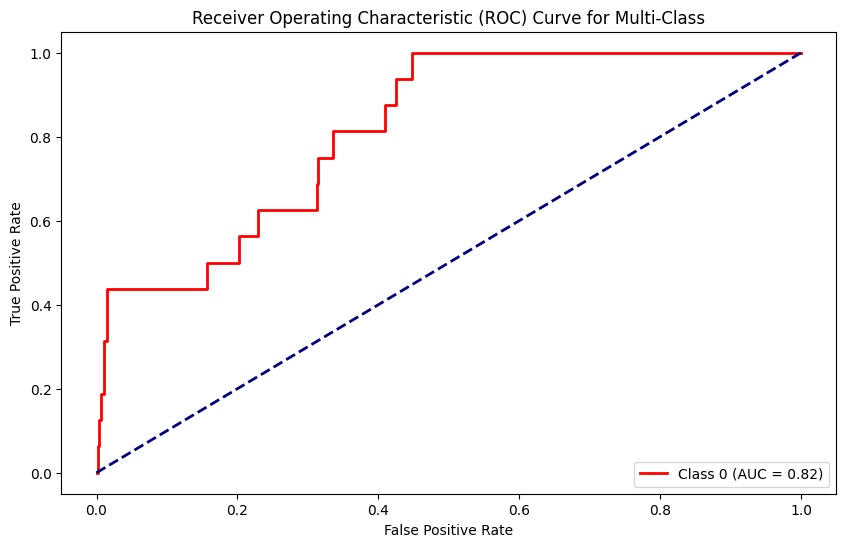

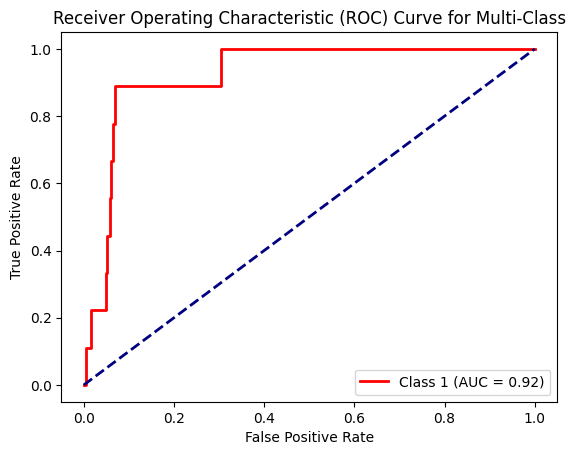

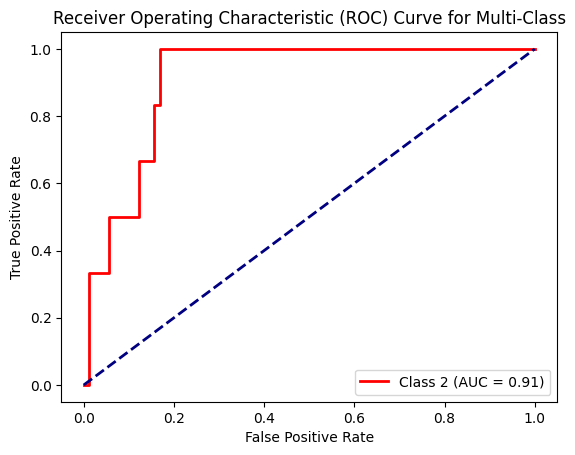

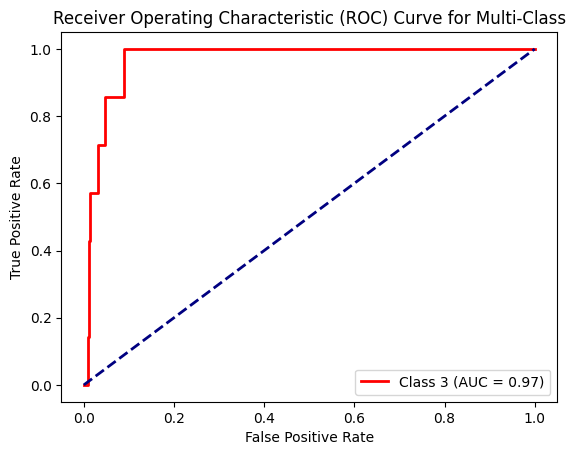

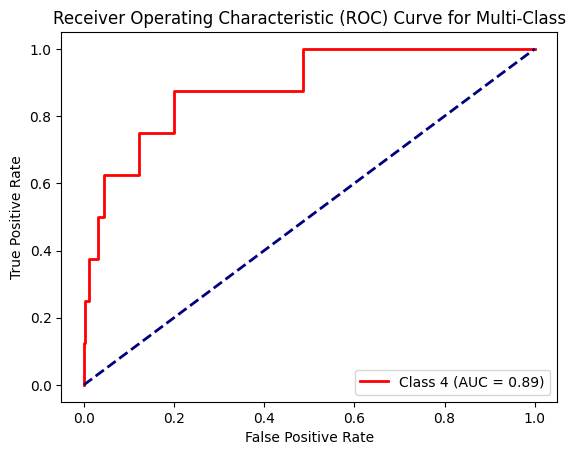

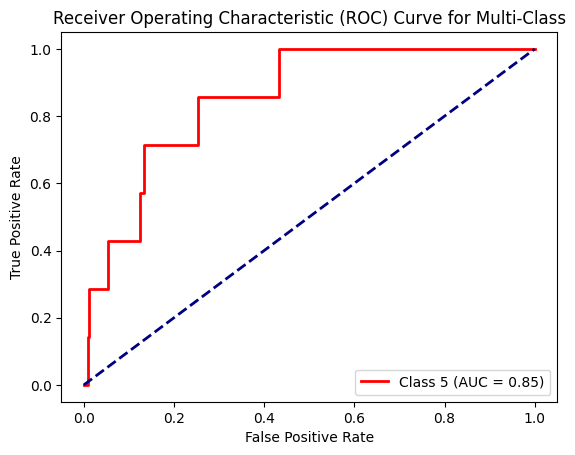

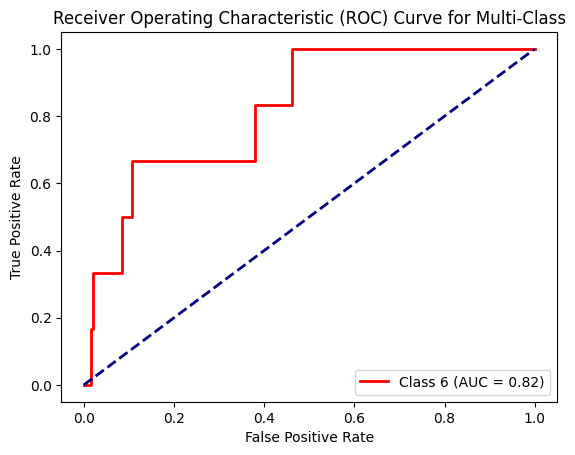

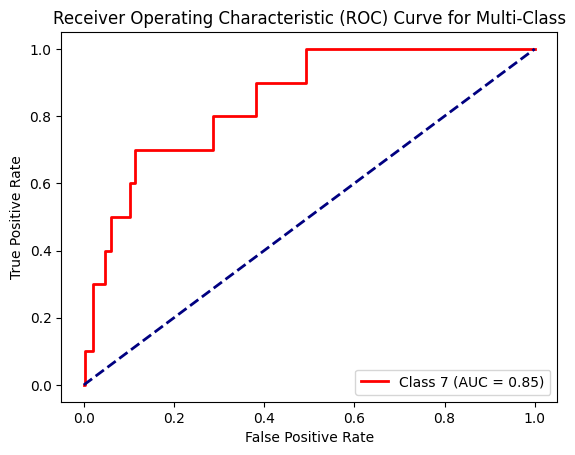

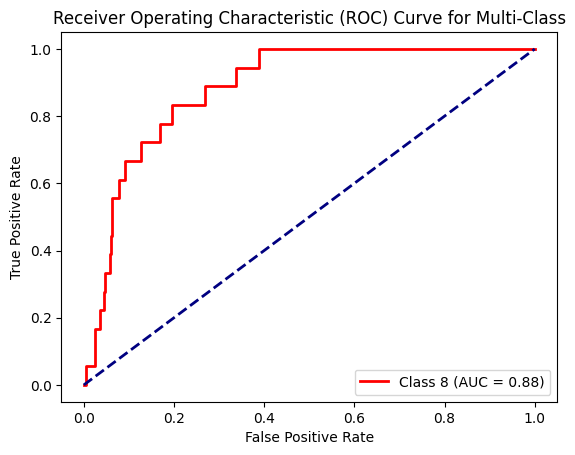

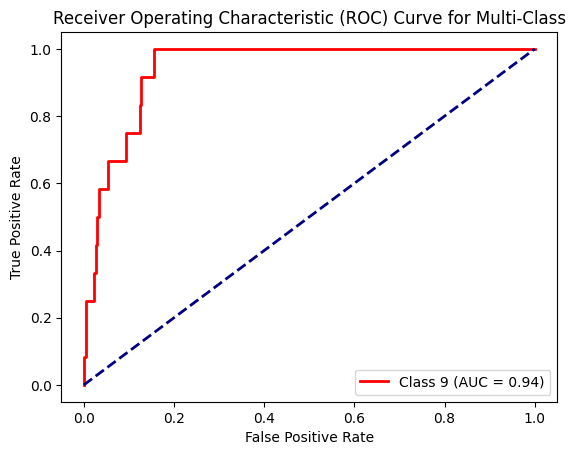

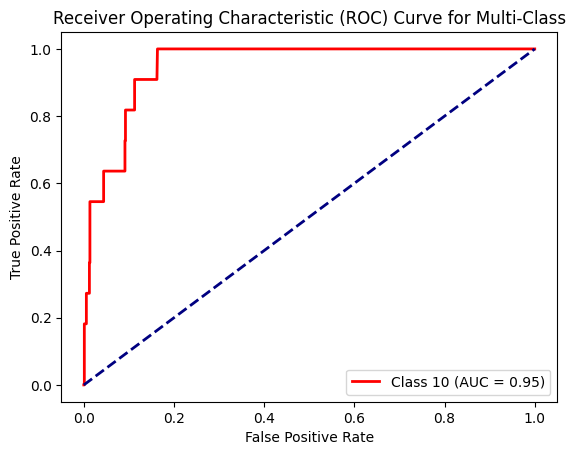

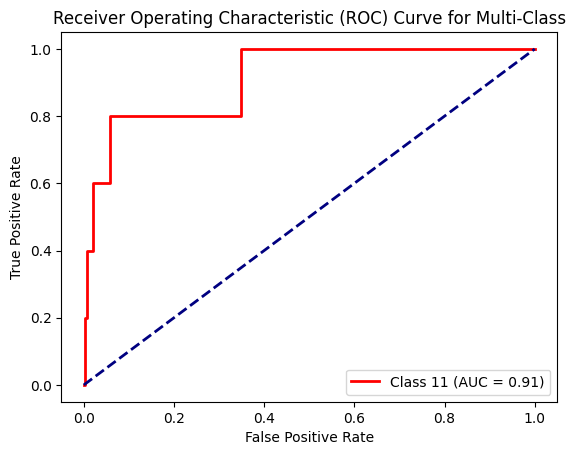

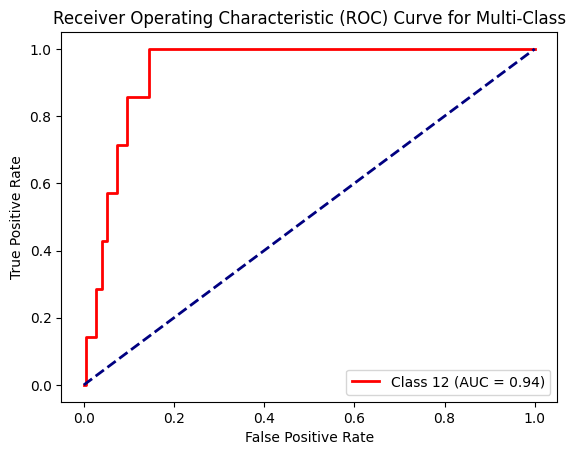

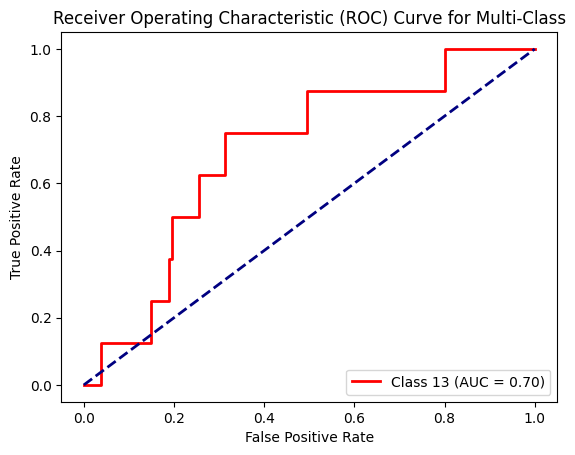

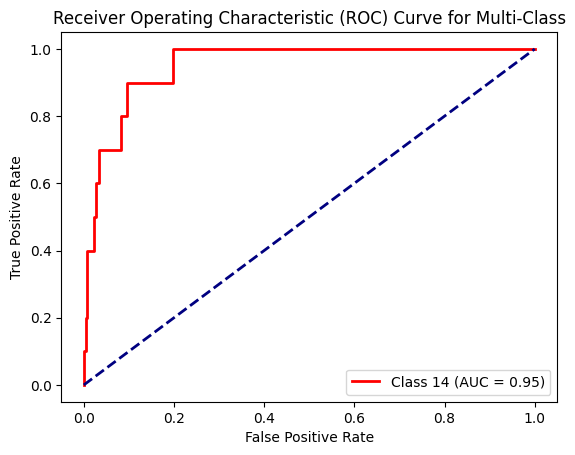

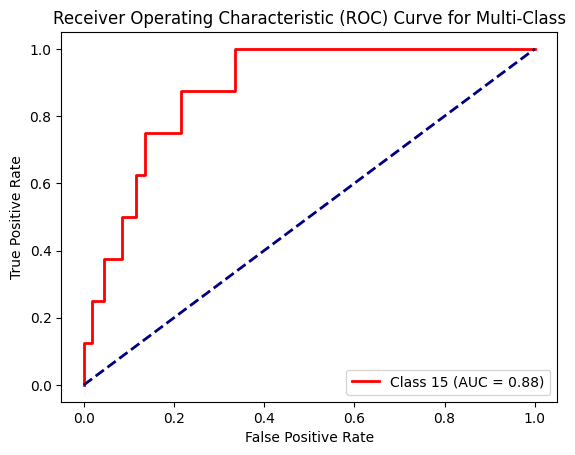

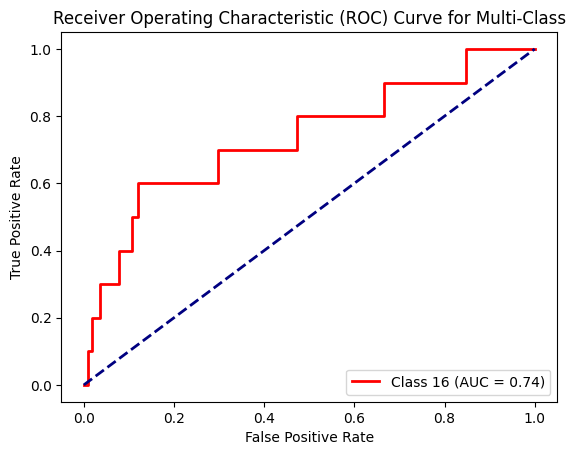

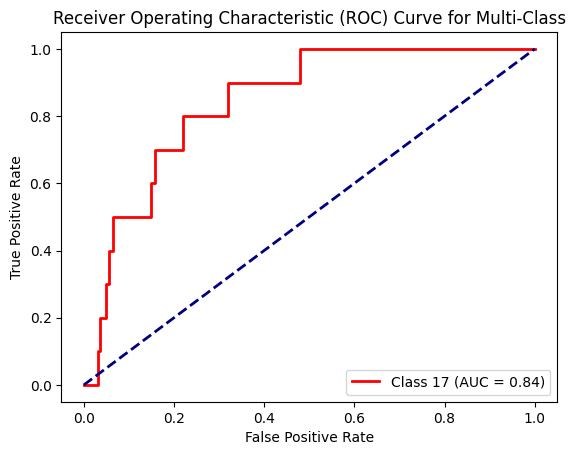

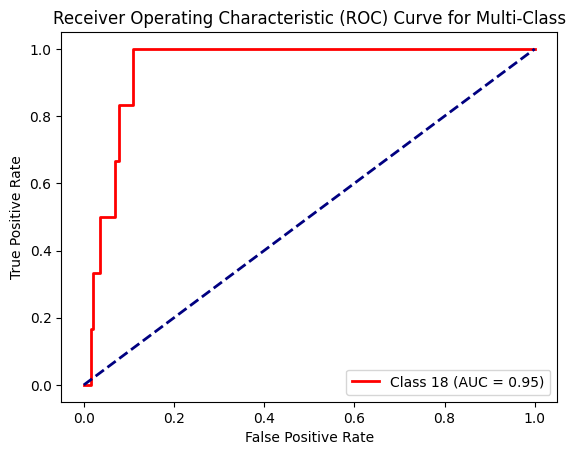

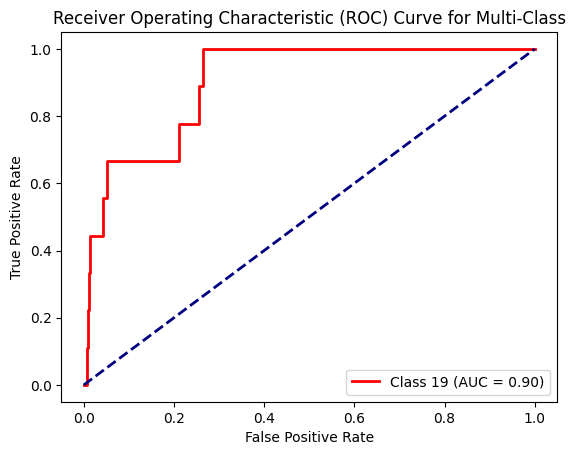

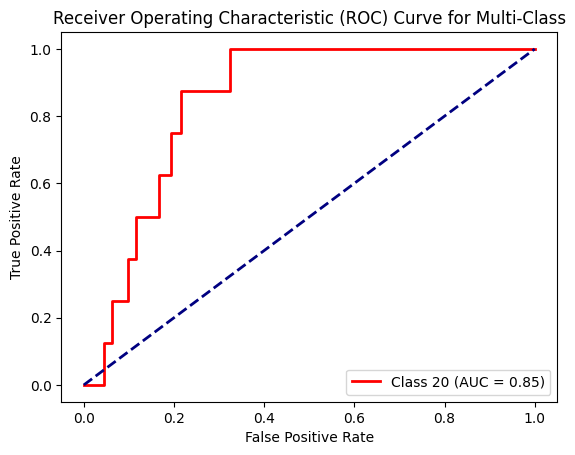

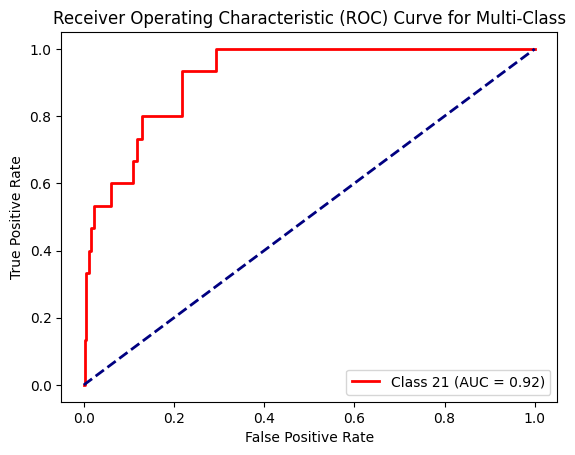

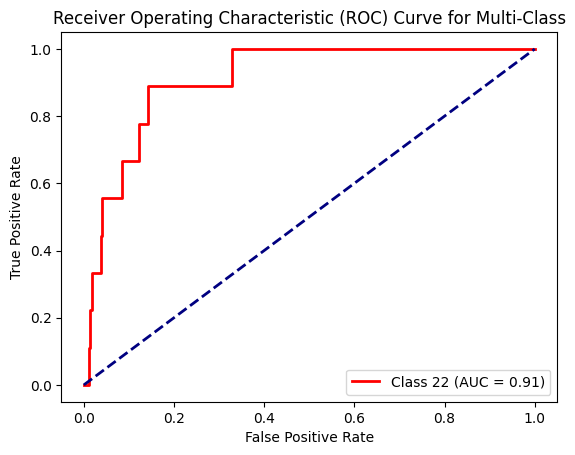

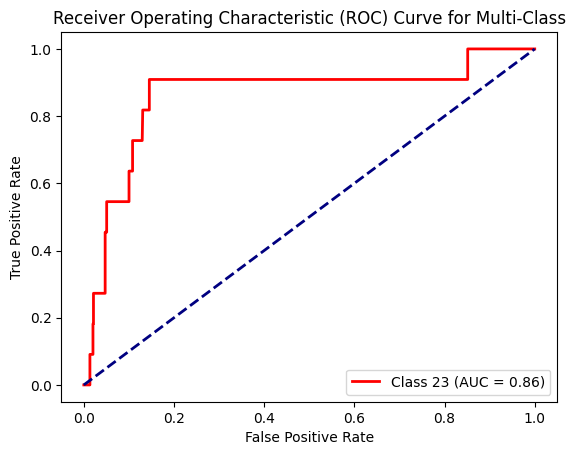

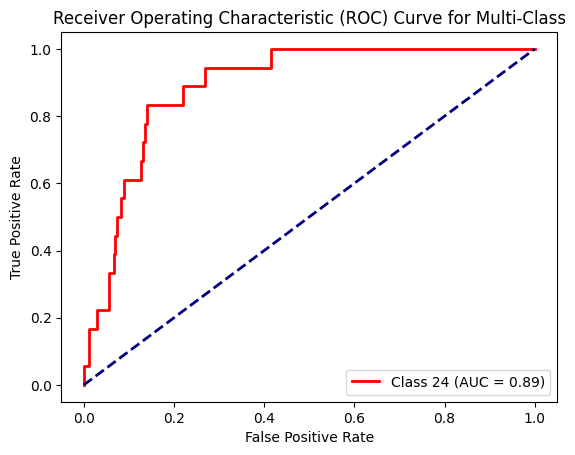

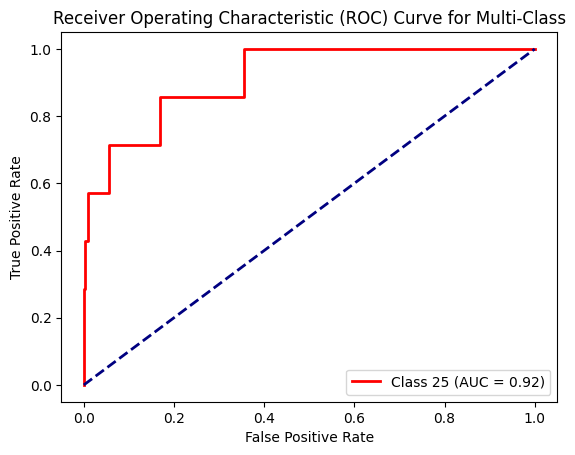

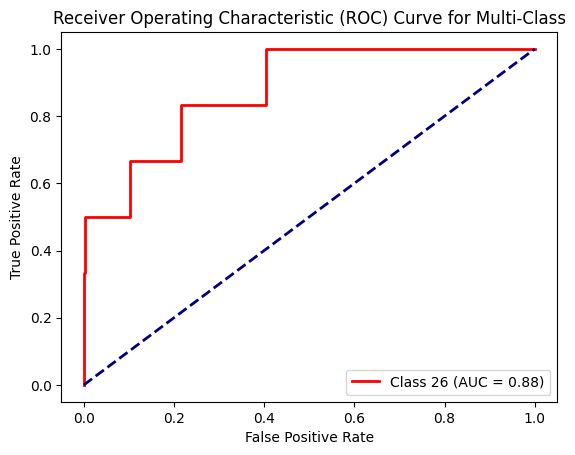

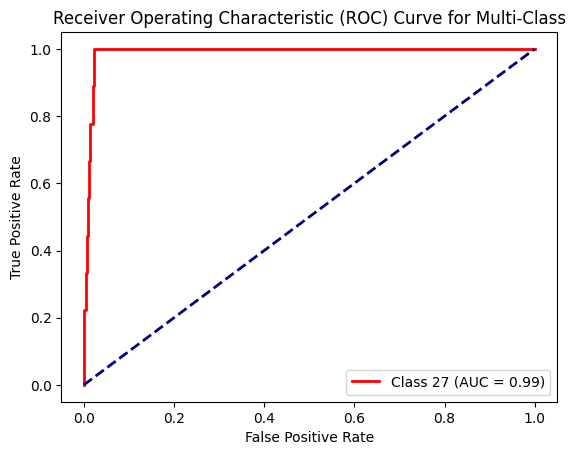

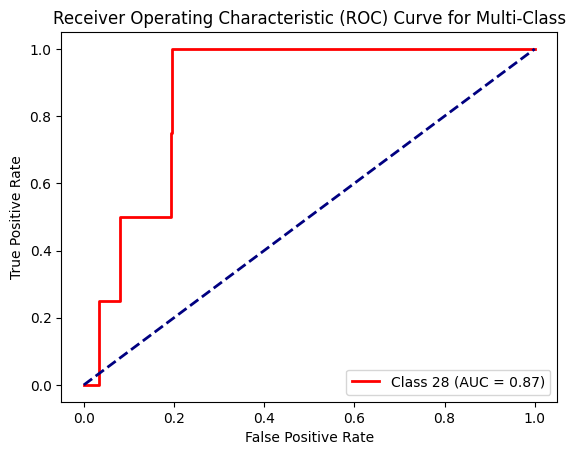

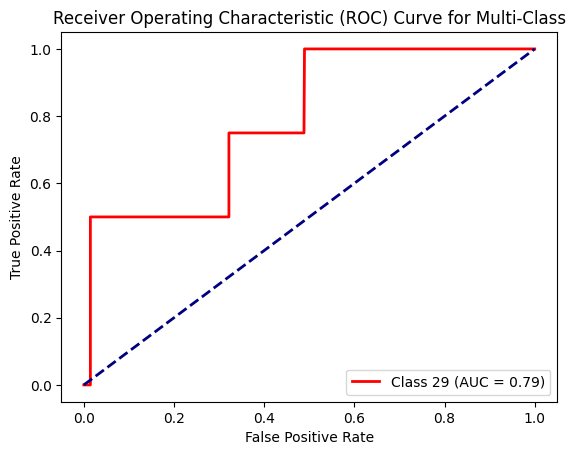

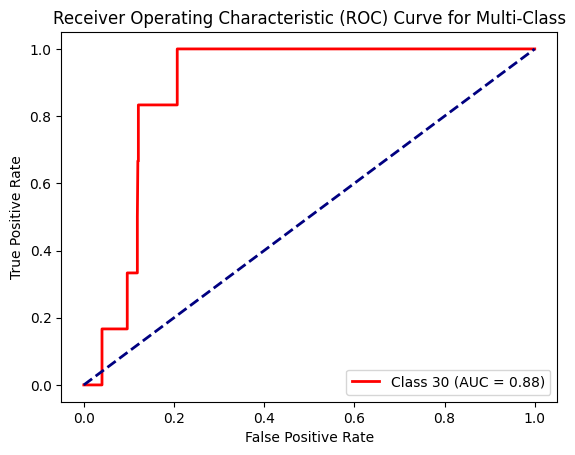

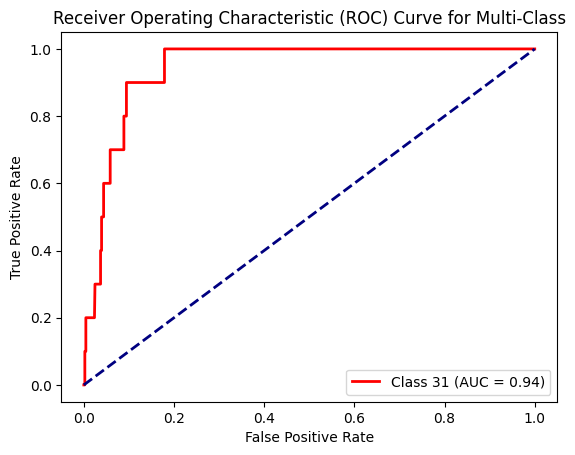

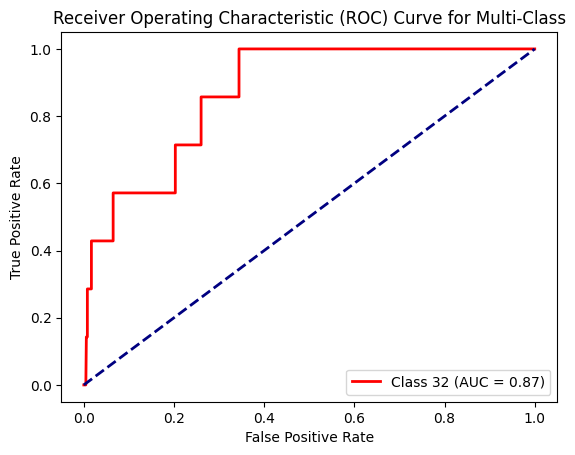

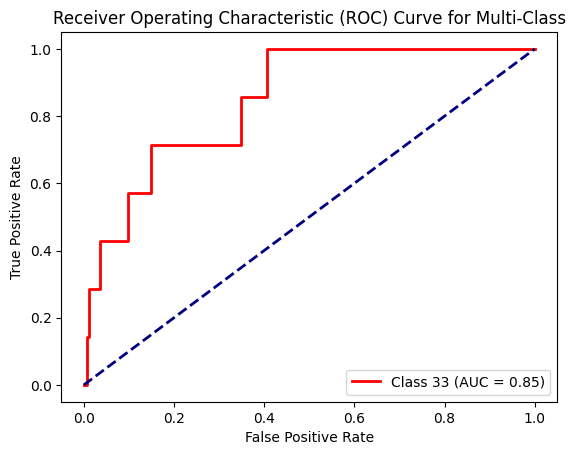

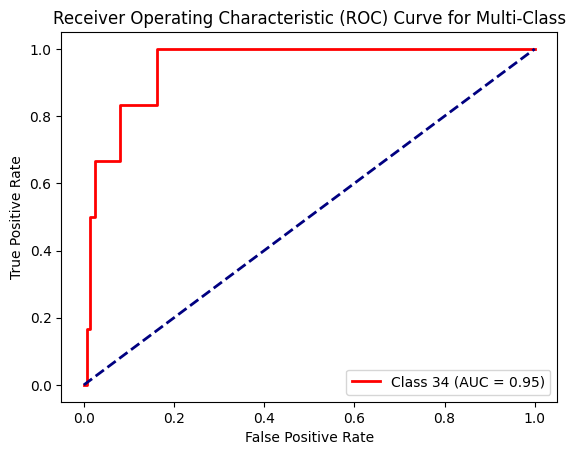

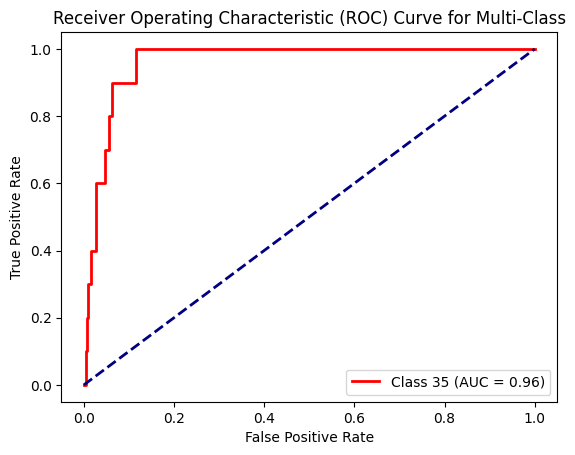

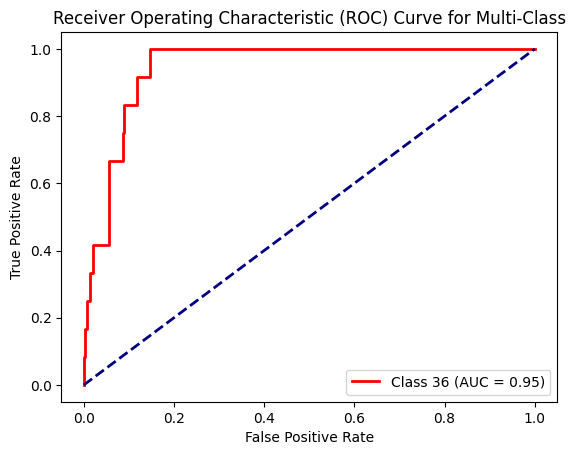

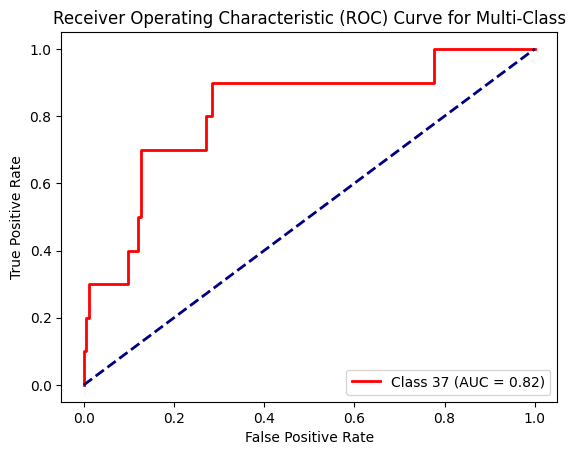

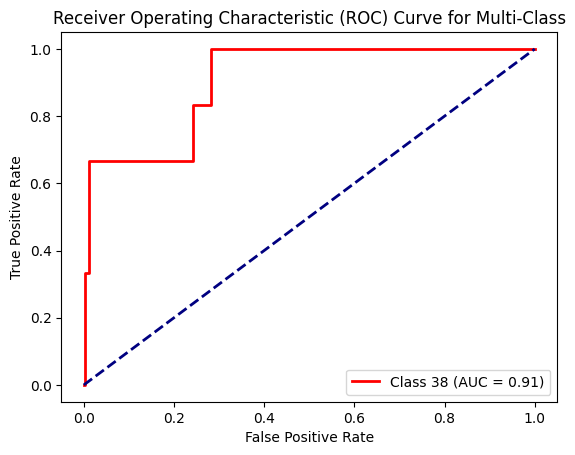

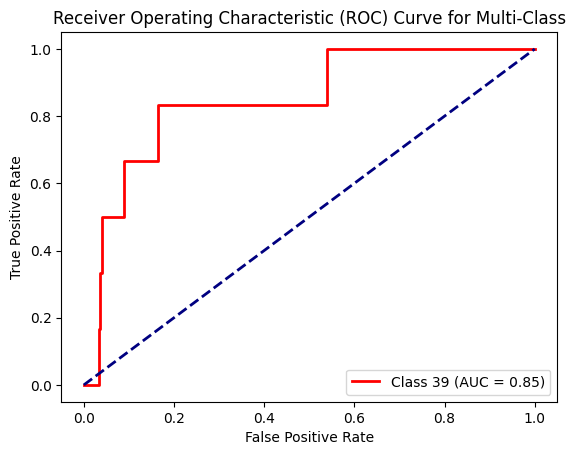

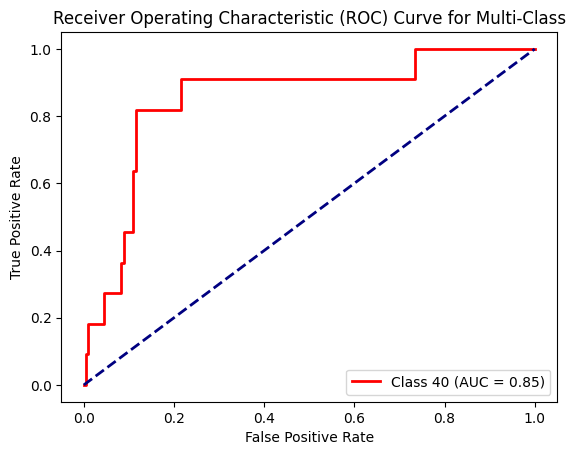

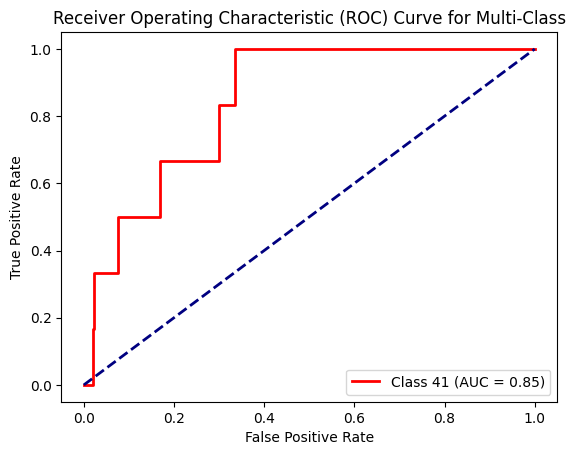

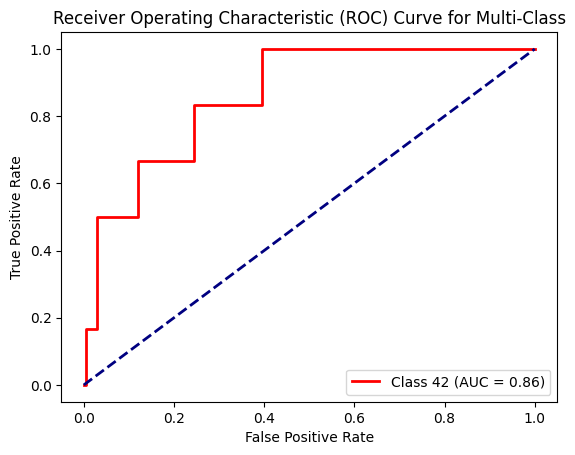

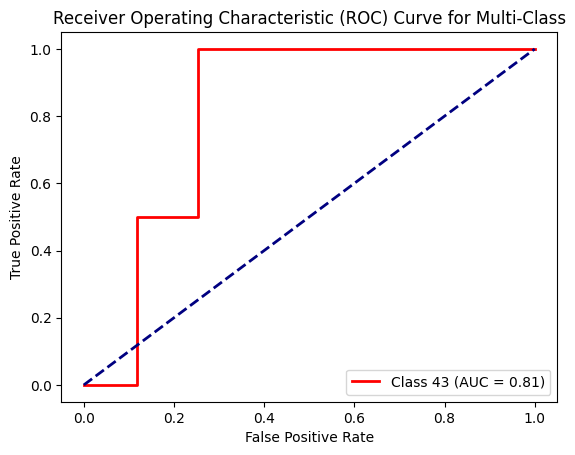

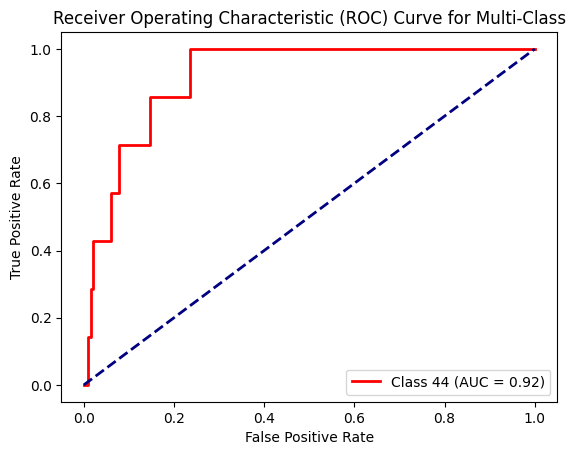

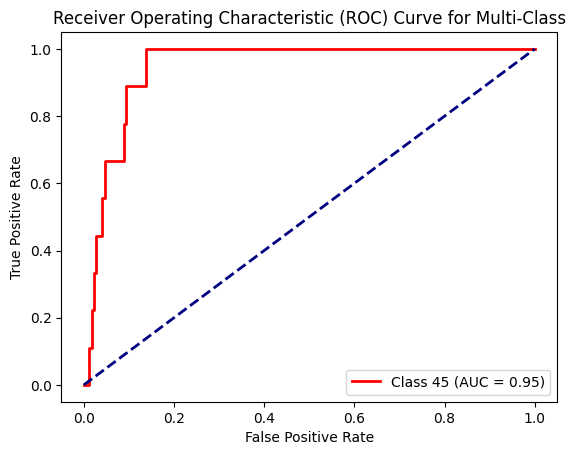

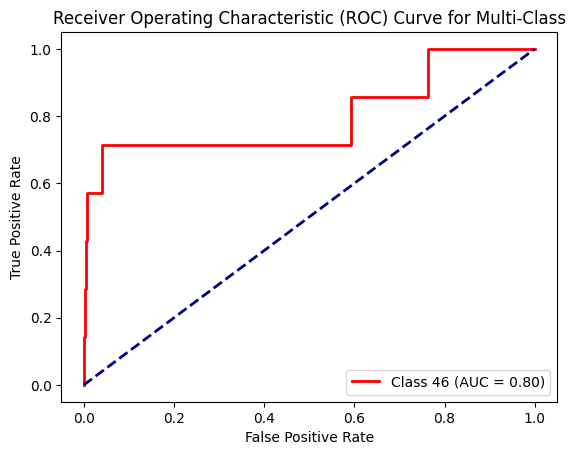

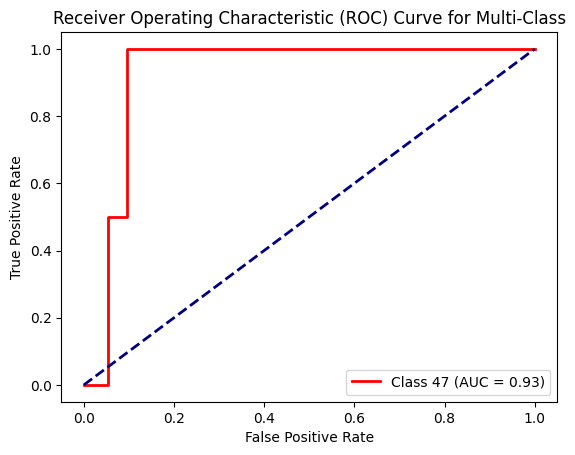

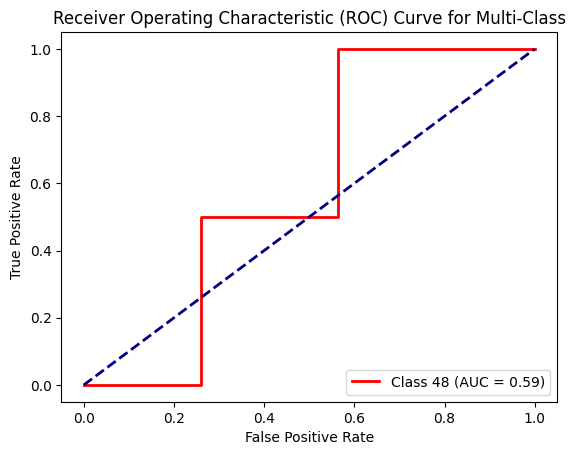

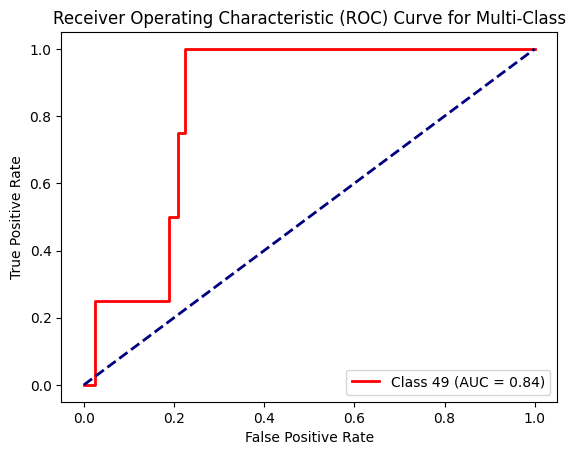

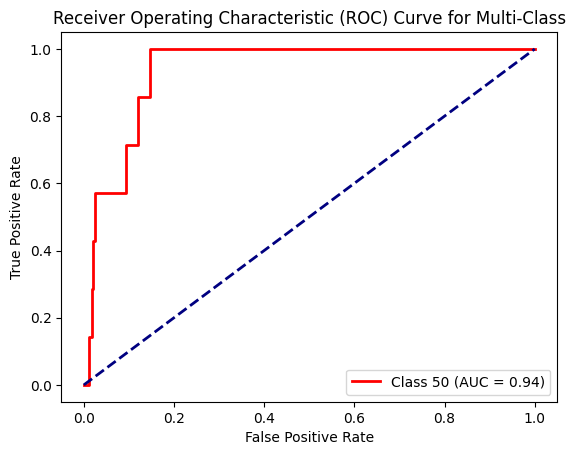

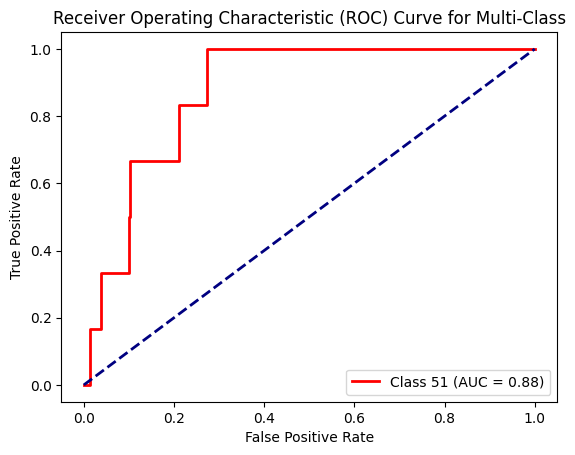

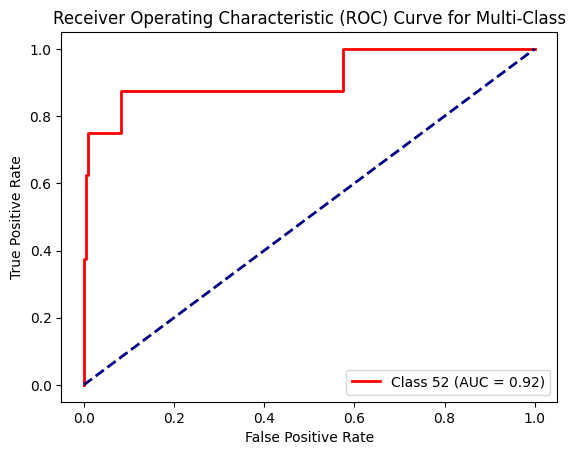

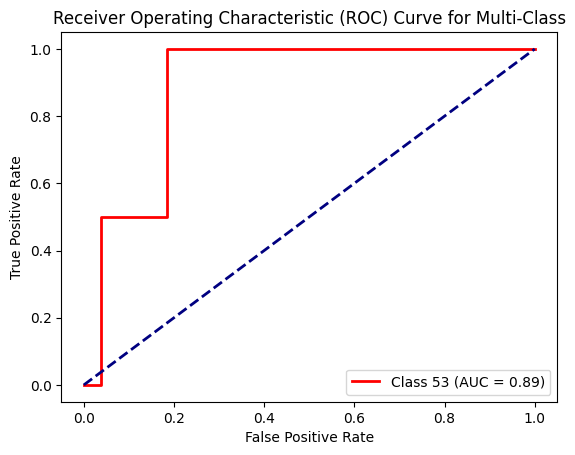

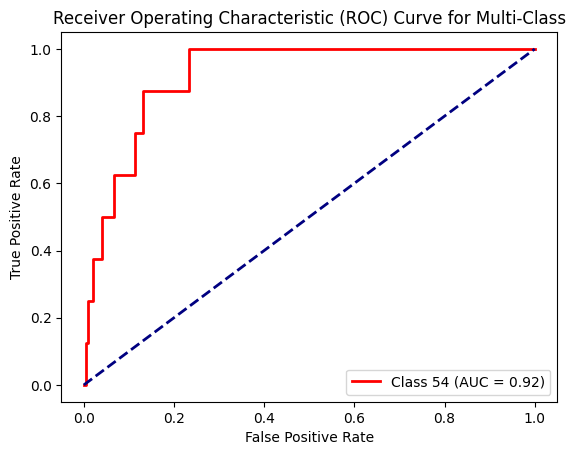

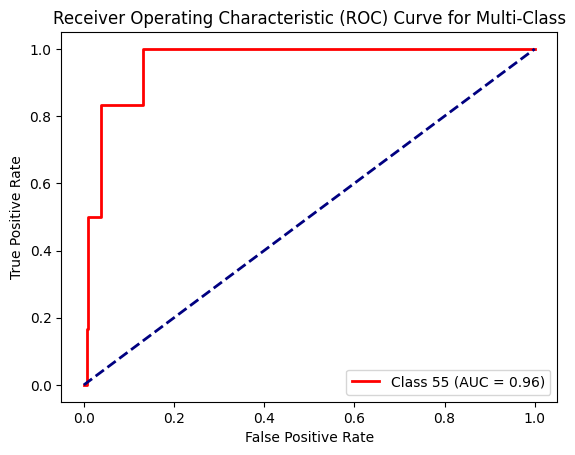

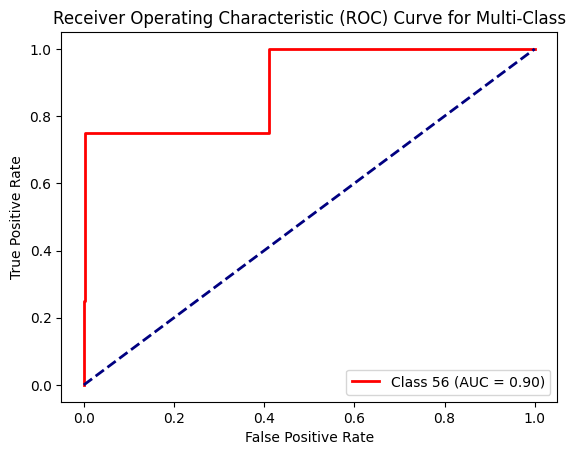

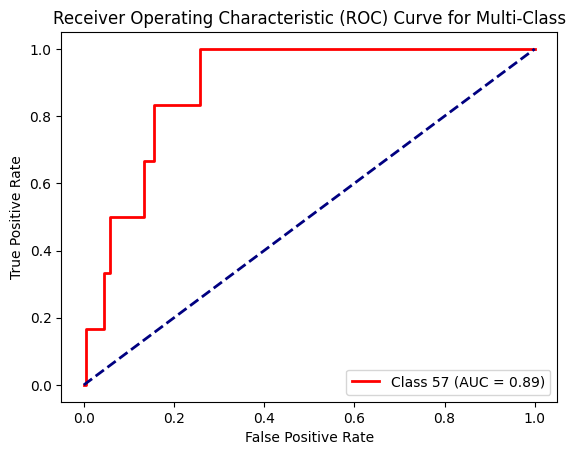

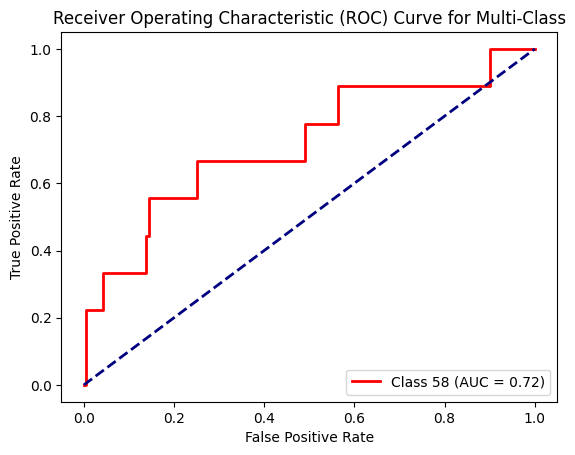

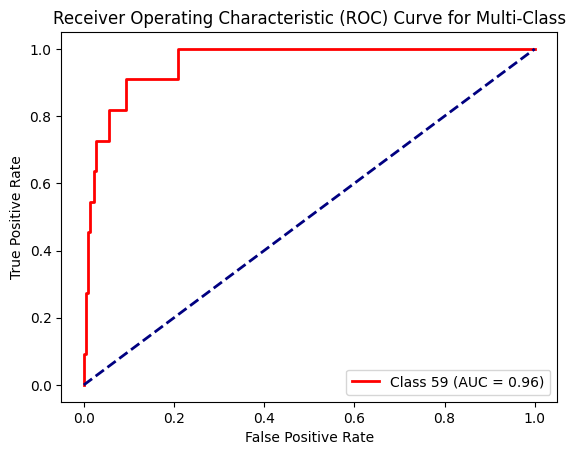

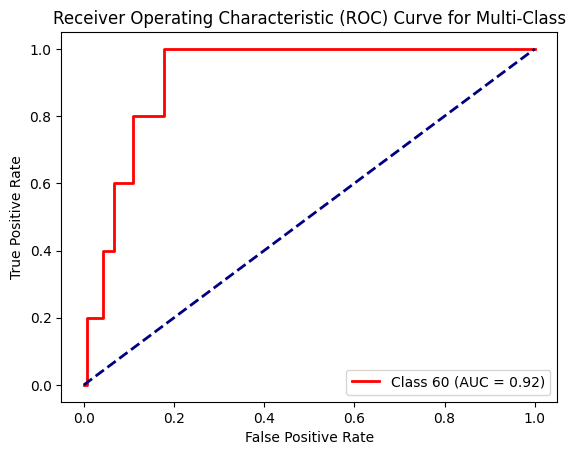

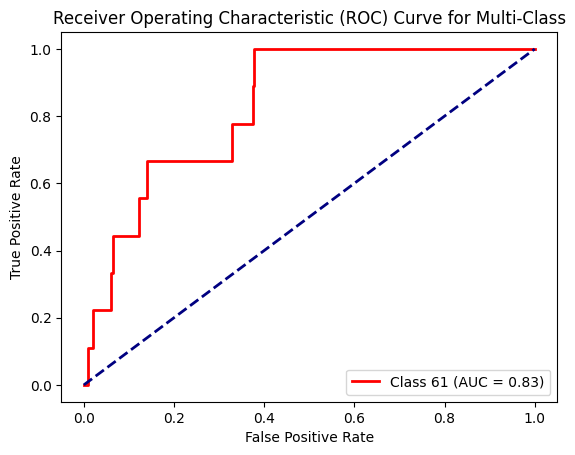

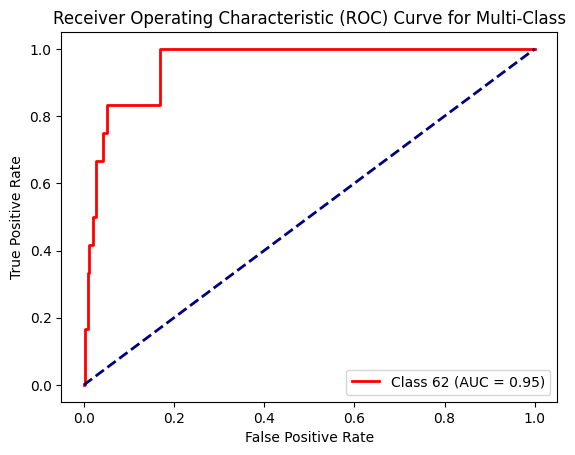

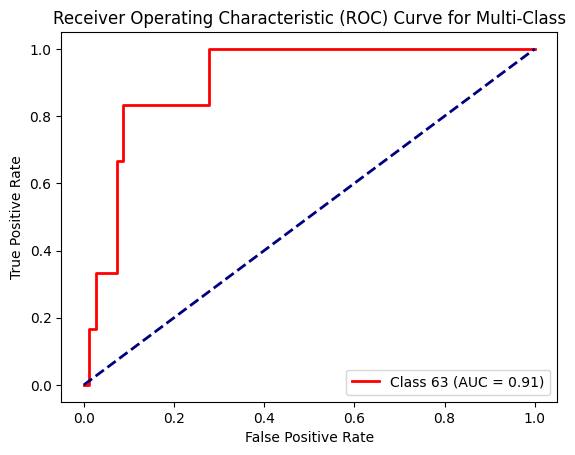

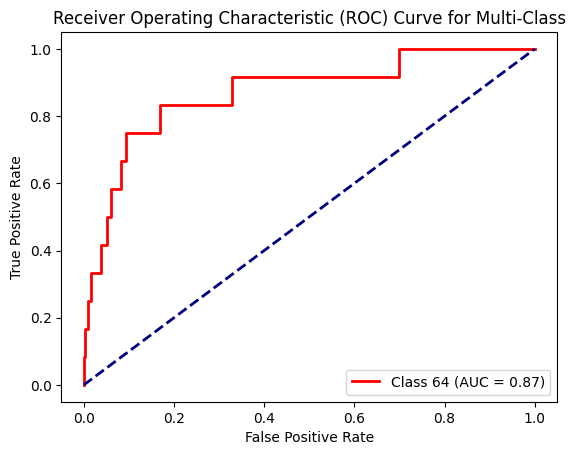

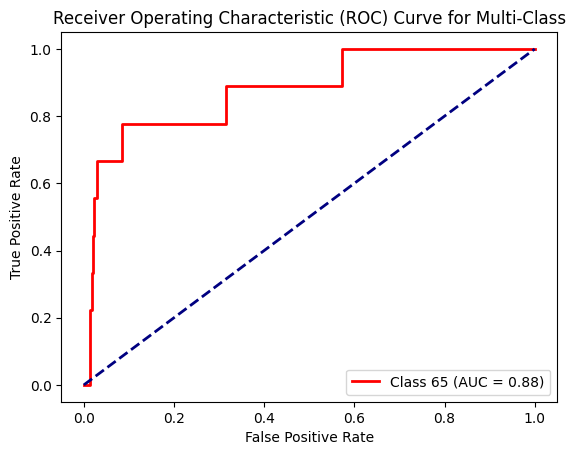

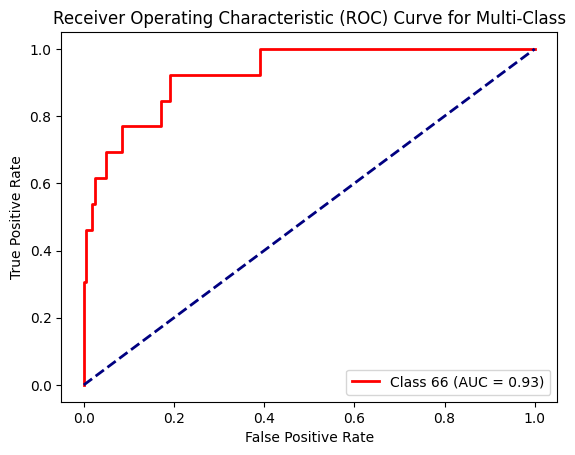

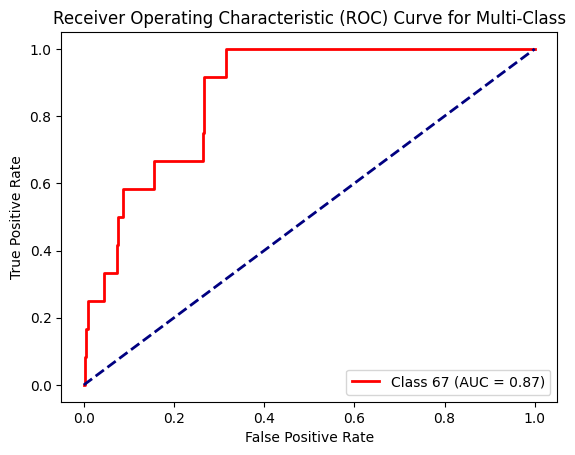

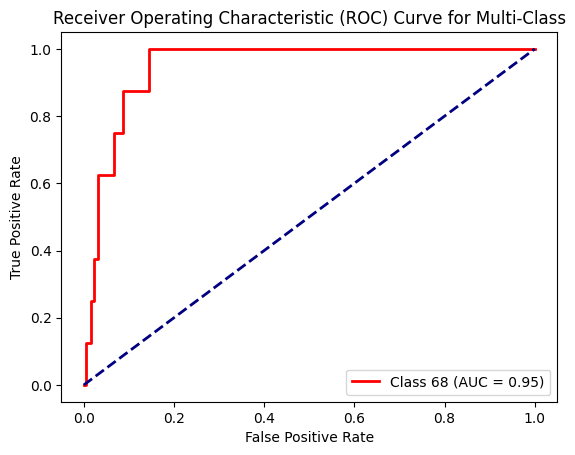

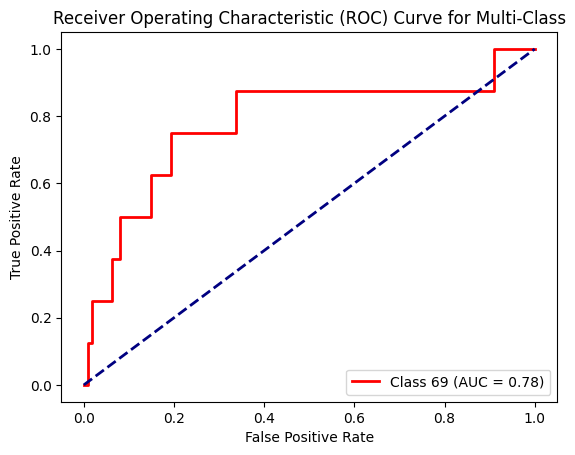

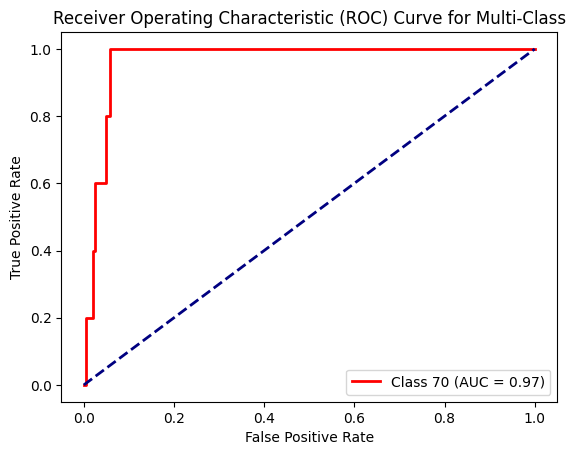

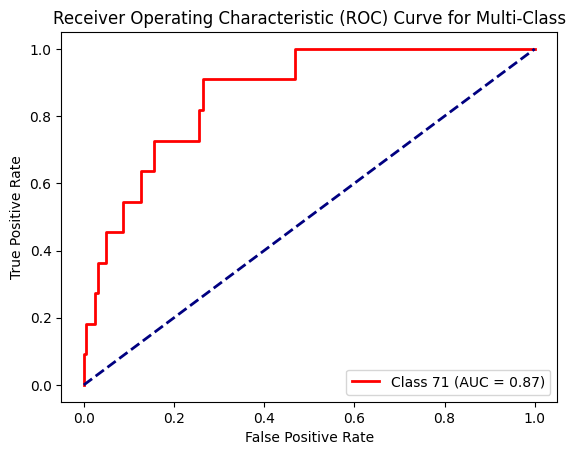

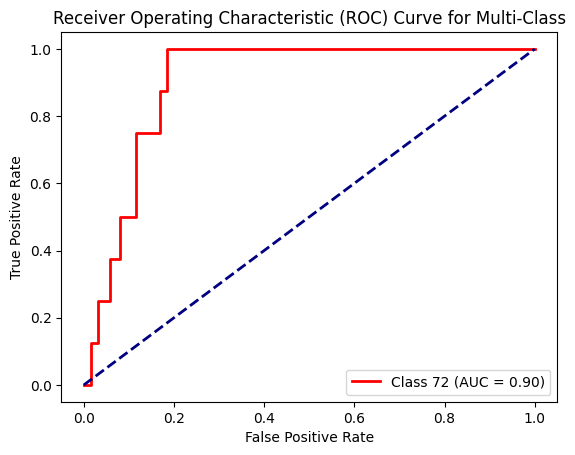

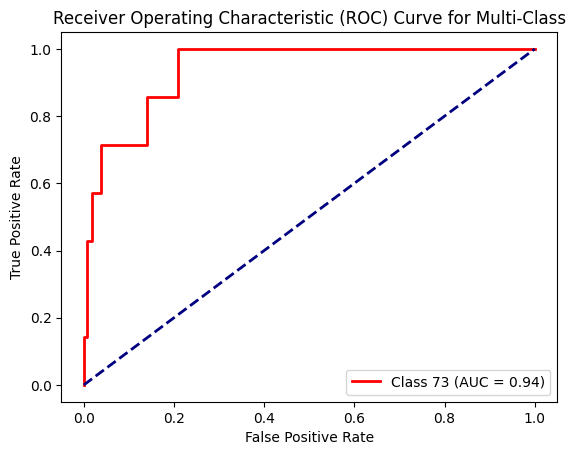

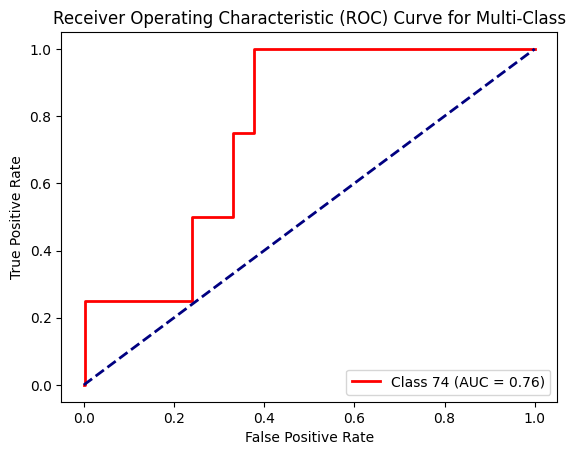

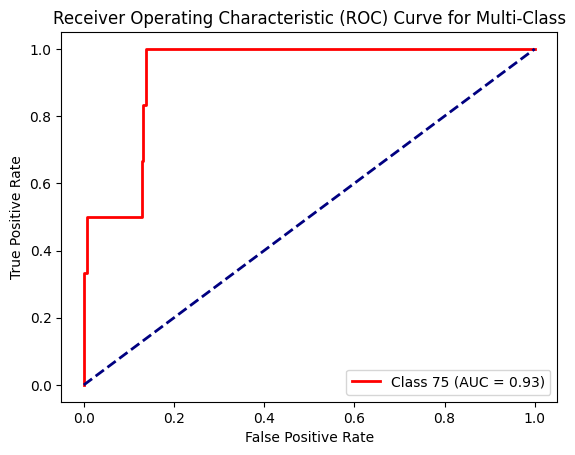

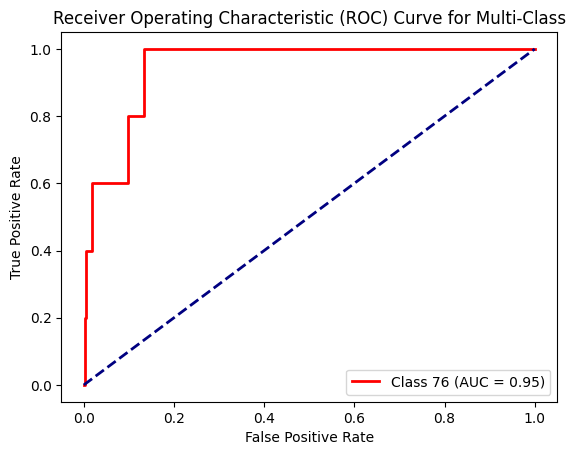

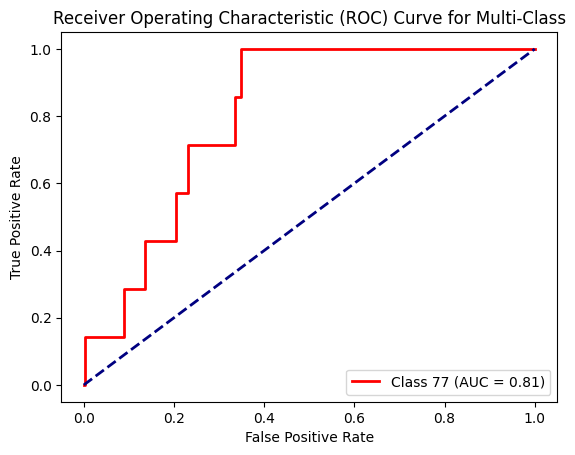

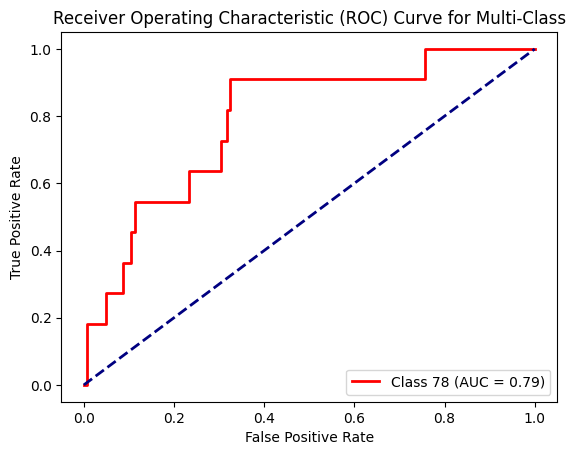

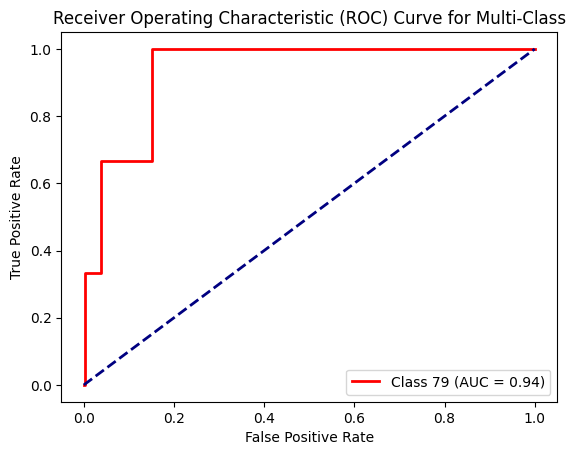

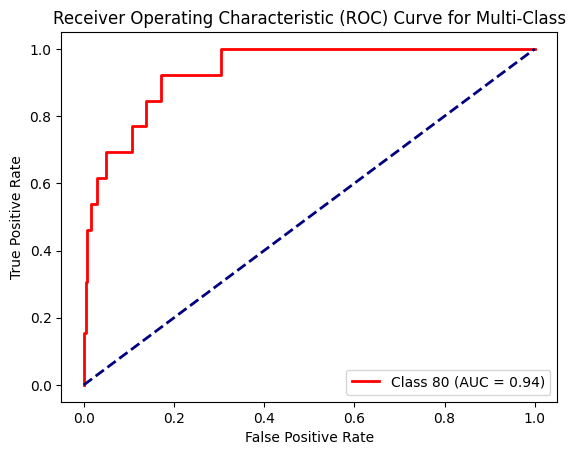

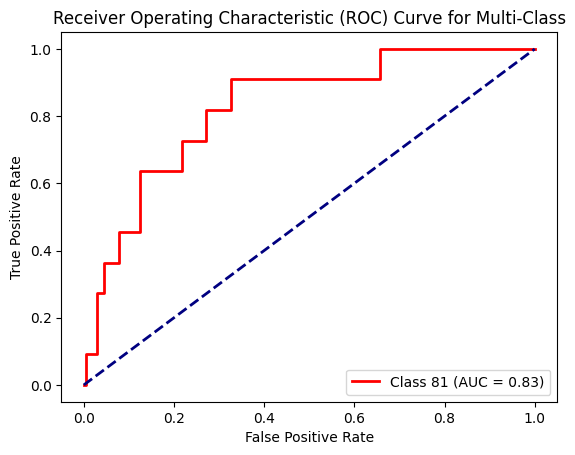

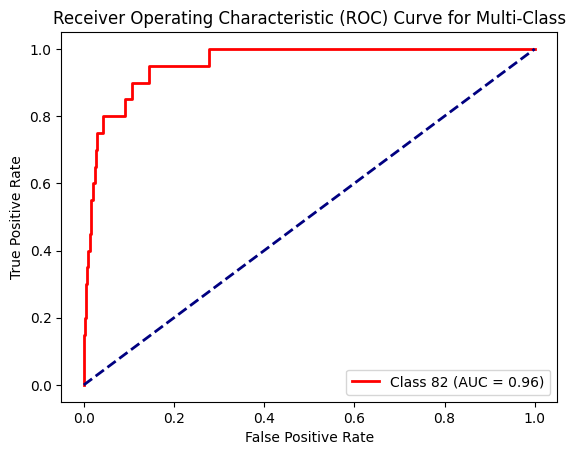

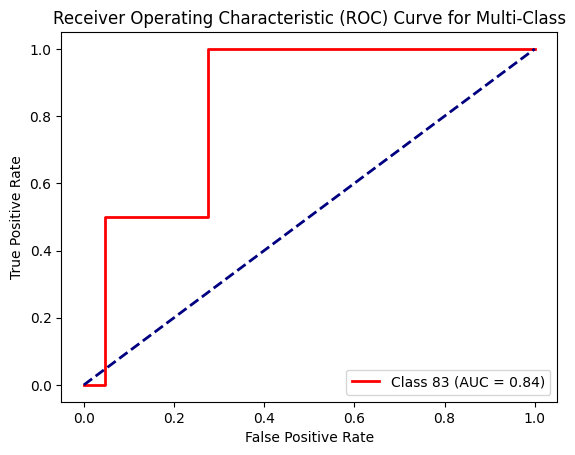

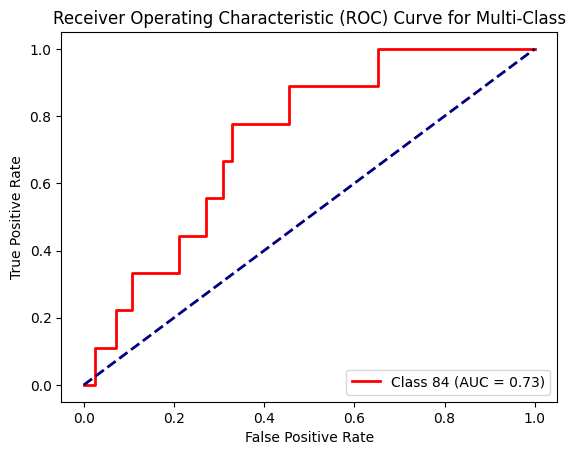

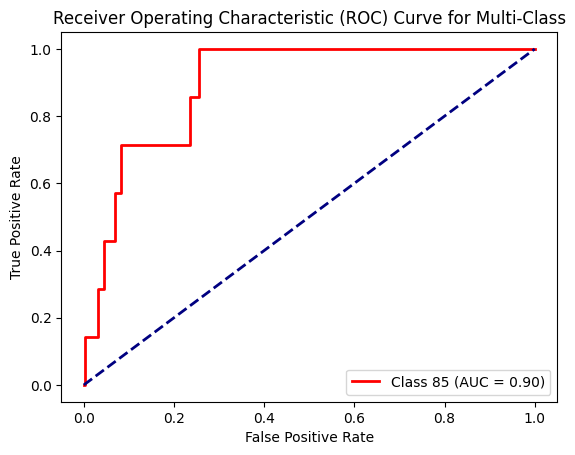

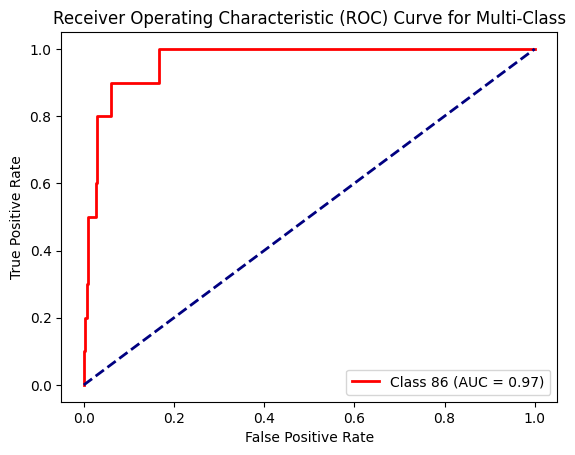

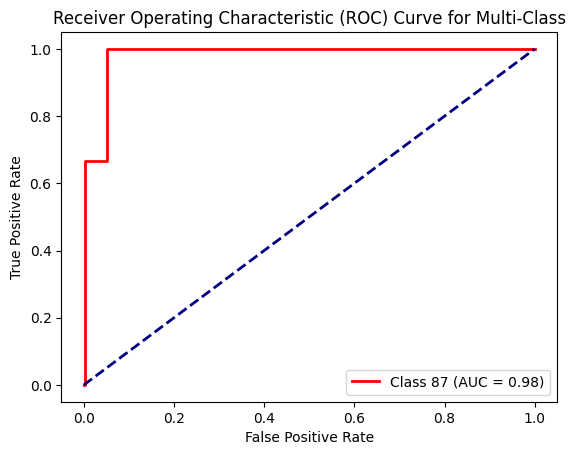

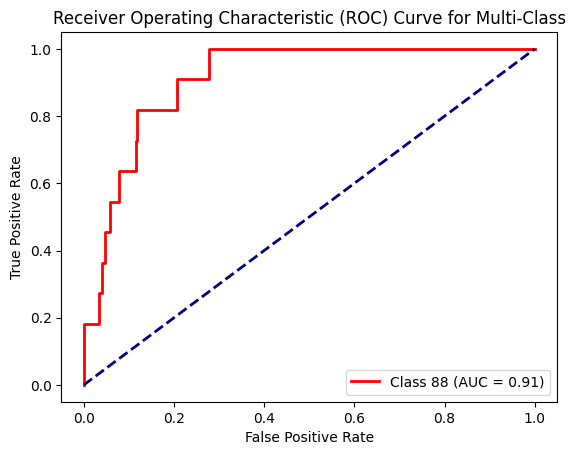

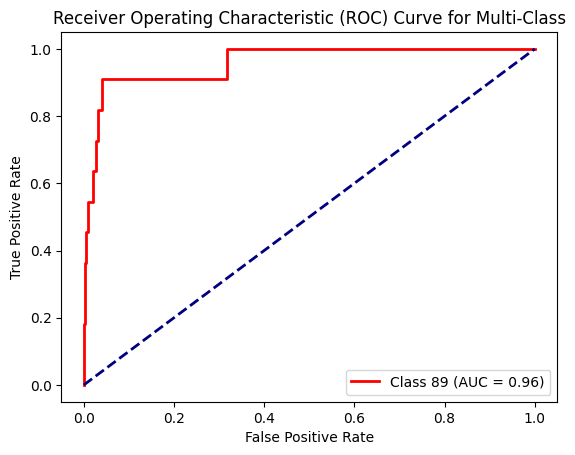

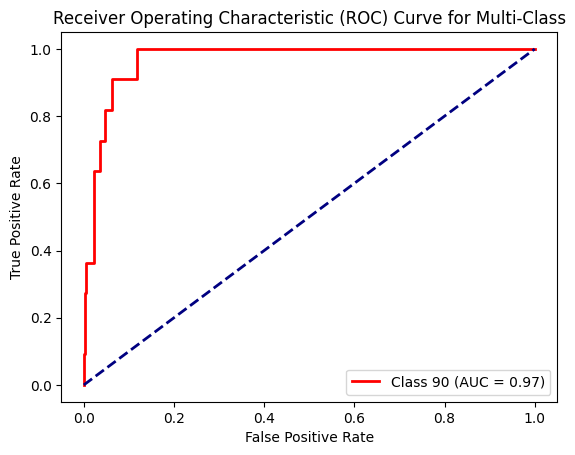

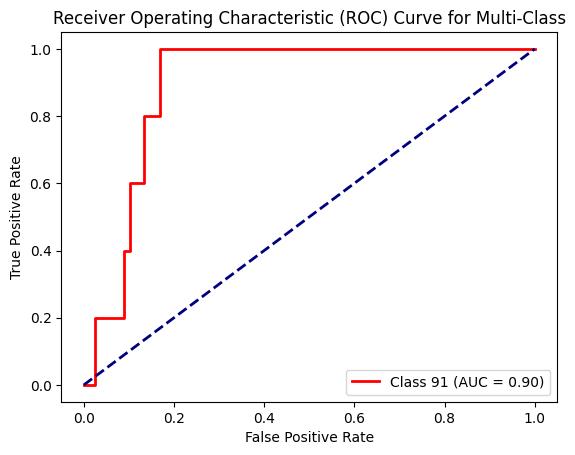

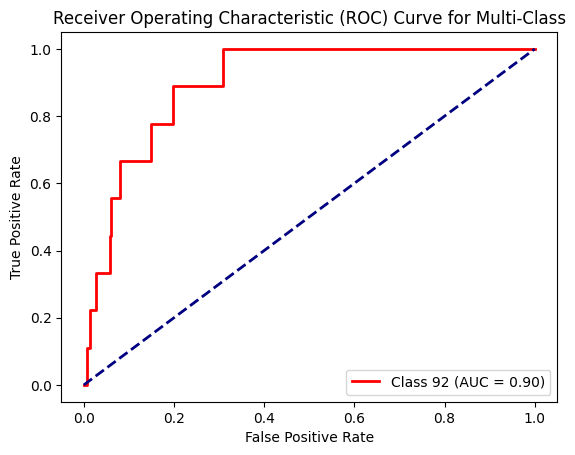

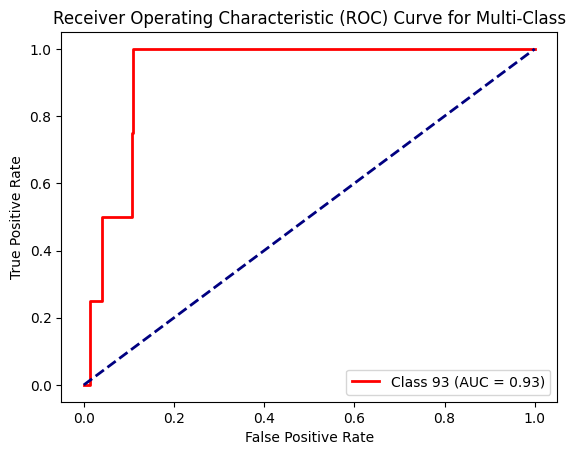

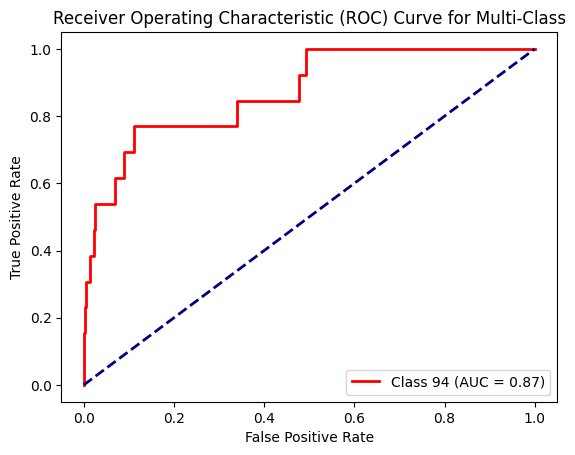

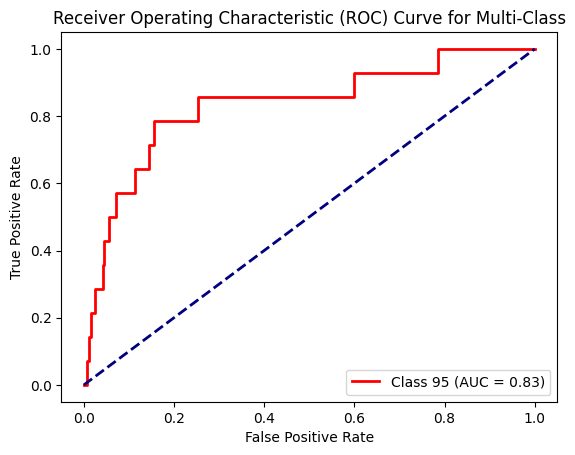

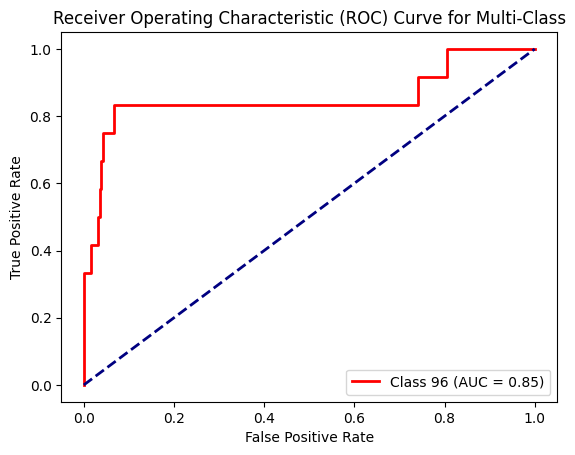

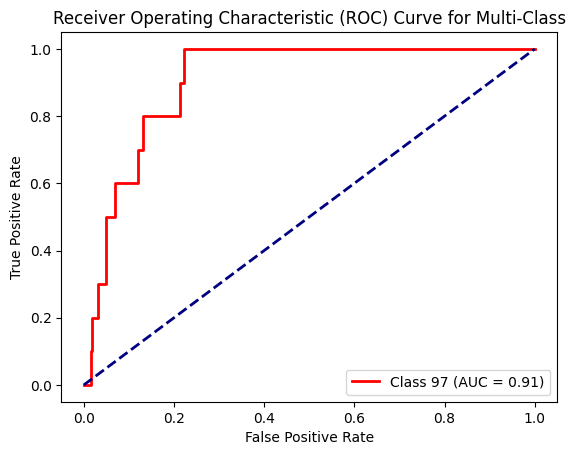

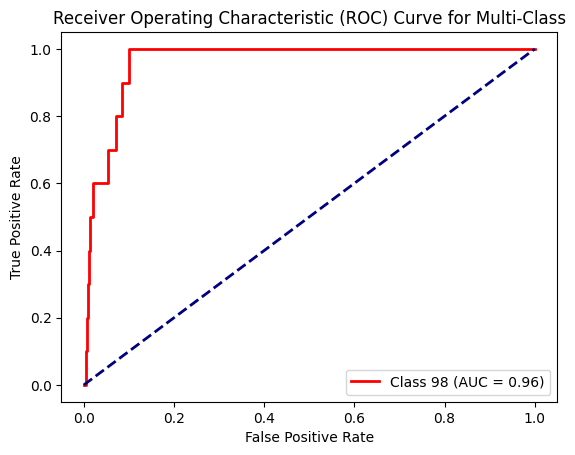

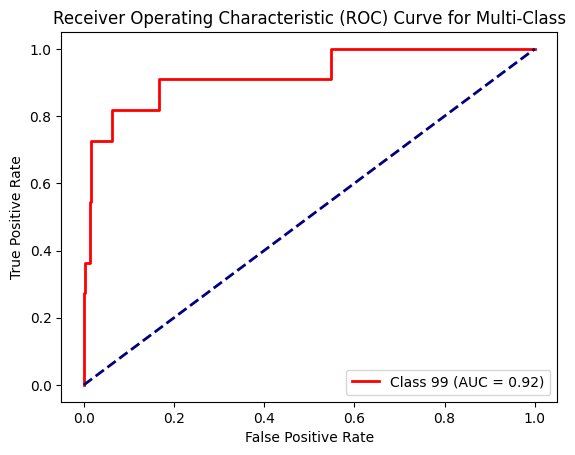

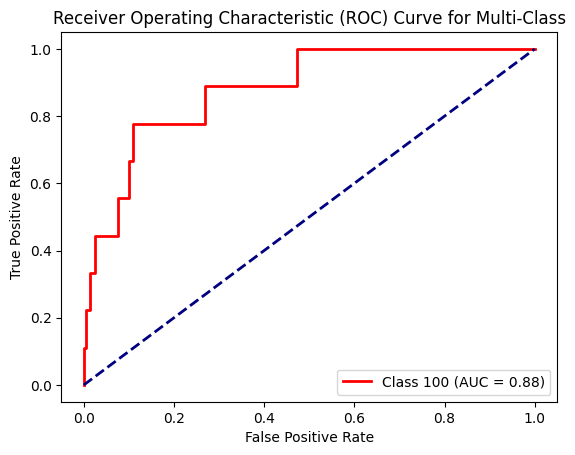

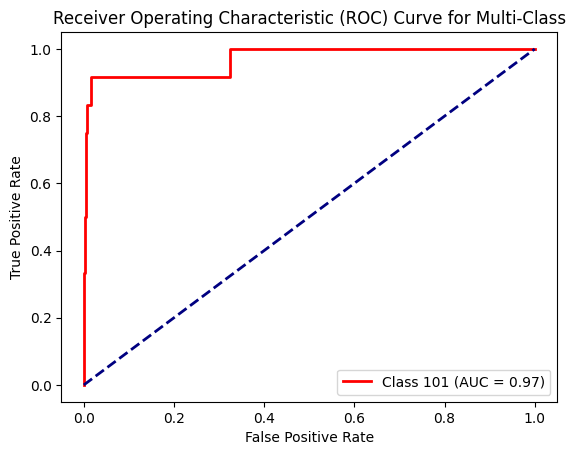

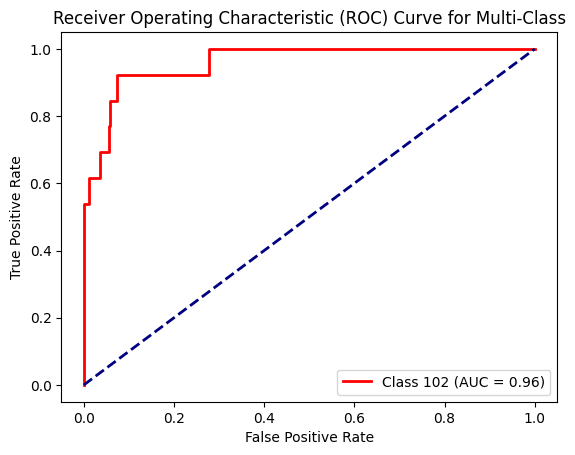

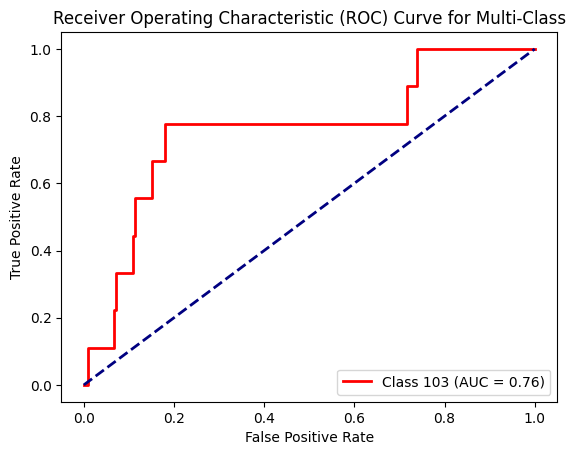

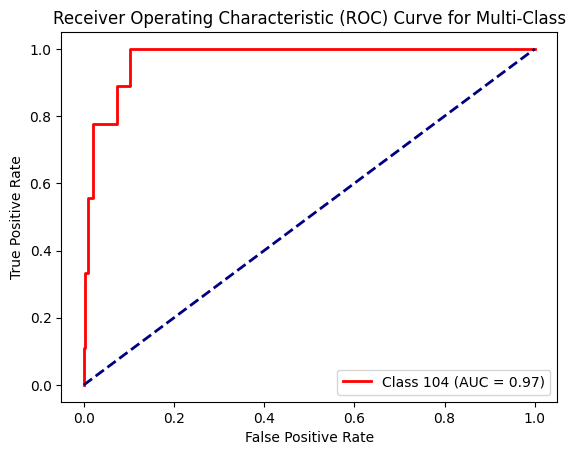

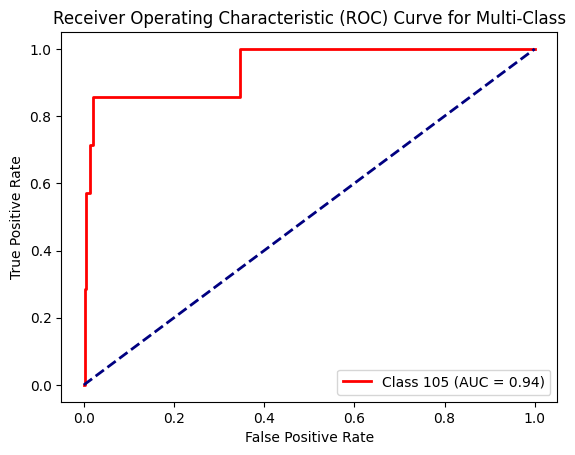

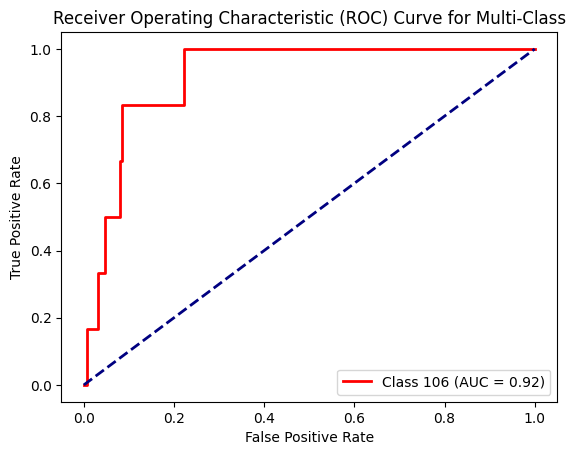

In [58]:
y_true = test_labels_one_hot
y_pred_prob = model.predict(test_data)

#fpr, tpr, thresholds = roc_curve(y_true, y_prob)
#roc_auc = auc(fpr, tpr)

# Initialize the OneVsRestClassifier
#classifier = OneVsRestClassifier(model)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(107):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6)) # Add more colors as needed
for i in range(107):
    plt.plot(fpr[i], tpr[i], color='red', lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# male:
# i = 29,30 

#### Other

In [ ]:
def int_to_asana(n):
    lista=[]
    for el in n:
        l=[key for key, value in labels_dict.items() if value == el]
        lista.append(l[0])
    return lista


def compare(test data, test_labels_one_hot, model):
    lab_pred = model.predict(test_data)
    pred_labels = np.argmax(lab_pred, axis=1)

    test_labels = np.argmax(test_labels_one_hot, axis=1)

    #asana_pred = int_to_asana(labels_pred)
    #asana_test = int_to_asana(test_labels)
    #df = pd.DataFrame({'pred': asana_pred, 'true': asana_test}, index=range(len(asana_pred)))

#### Ways to improve the model:
- train set percentage
- data augmentation parameters
- num_layers and filters
- opt function and learning rate
- batch_size
- num_epochs + add early_stopping
- layer dense